**TO-DO**
* assinalar que owners é que têm um disponent

## Table Of Contents <a id="index"></a>


- [Dataset managing](#dataset)  
- [District Data](#district-data)
- [Data Exploration](#data-exploration)
- [Matrix](#matrix)
  

#### Models
- [**Decision Tree**](#decision-tree)
    - [**Parameter Tunning**](#parameter-tunning)
- [**K-Nearest Neighbor**](#k-nearest-neighbor)
    - [**Parameter Tunning**](#parameter-tunning-2)  
- [**Support-Vector Machines**](#support-vector-machines)
    - [**Parameter Tunning**](#parameter-tunning-3)
- [**Neural Networks**](#neural-networks)
    - [**Parameter Tunning**](#parameter-tunning-4)
- [**Logistic Regression**](#logistic-regression)
- [**Naive Bayes**](#naive-bayes)
- [**Random Forest**](#random-forest)
- [**XGBoost**](#xgboost)
- [**MLP**](#mlp)
- [**Ada Boost**](#ada-boost)
- [**Voting**](#voting)

#### [Apply Model](#apply-model)



In [72]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import plotly.graph_objects as go
from sklearn.ensemble import AdaBoostClassifier

In [2]:
def dataset(x, missing = ""):
    return pd.read_csv('Dataset/' + x + '.csv', sep = ';', low_memory = False, na_values = missing_values).rename(str.strip, axis = 'columns')

In [3]:
missing_values = ['?', 'NA', '']
account_data = dataset('account', missing_values)
client_data = dataset('client', missing_values)
disp_data = dataset('disp', missing_values)
district_data = dataset('district', missing_values)
card_train = dataset('card_train', missing_values)
card_test = dataset('card_test')
loan_train = dataset('loan_train', missing_values)
loan_test = dataset('loan_test')
trans_train = dataset('trans_train', missing_values)
trans_test = dataset('trans_test')

We can see the distribution of the district regions for each one of the different regions.

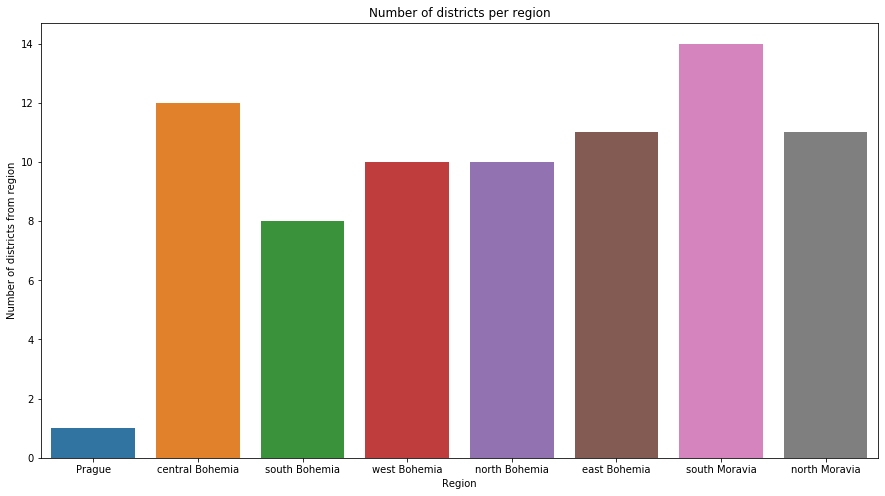

In [4]:
plt.figure(figsize=(15,8))
sb.countplot(x='region', data=district_data)
plt.title("Number of districts per region")
plt.xlabel('Region');
plt.ylabel('Number of districts from region');
plt.show()

To study if the region might have an impact on the acceptance of the loan we will create a graph comparing the percentages of successful loans per region.

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


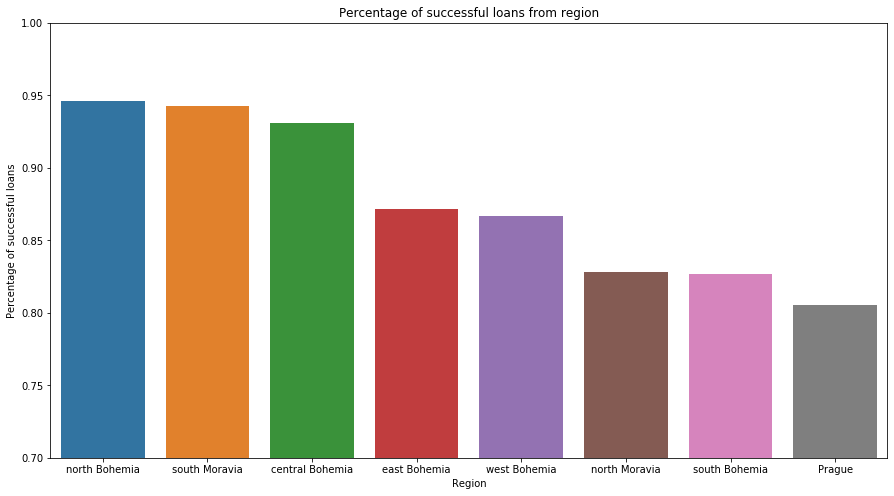

In [5]:
district_data_region = district_data.copy()
region_data = loan_train
region_data = pd.merge(region_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
region_data = pd.merge(region_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
region_data = pd.merge(region_data, district_data_region.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))

region_total = region_data["region"].value_counts()
tuples_total = [tuple((x, y)) for x, y in region_total.items()]

regions_status_1 = region_data.loc[region_data['status'] == 1]
region_total_1 = regions_status_1["region"].value_counts()
tuples_total_1 = [tuple((x, y)) for x, y in region_total_1.items()]

lista=[]
for x in tuples_total:
    for y in tuples_total_1:
        if x[0]==y[0]:
            lista.append((x[0],x[1],y[1]))

percentages = [(i[0],i[2] / i[1]) for i in lista]
percentages.sort(key = lambda x: -x[1])

x = [i[0] for i in percentages]
y = [i[1] for i in percentages]

plt.figure(figsize=(15,8))
sb.barplot(x,y)
plt.ylim(0.7, 1)
plt.title("Percentage of successful loans from region")
plt.xlabel('Region');
plt.ylabel('Percentage of successful loans');
plt.show()

Now let's see the different values the parameter type can have.

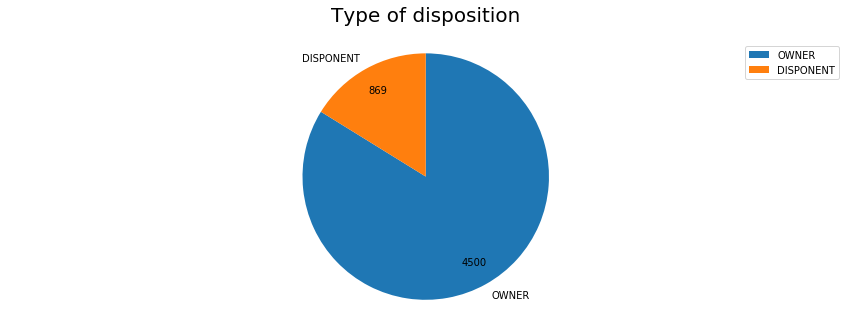

In [6]:
disp_data_pie = disp_data.copy()

ser = disp_data_pie.groupby('type')['type'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=ser.index, startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Type of disposition', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

Since only owner can issue permanent orders and ask for a loan, there is no interess in keeping this parameter in our dataset.

In [7]:
# Removing name and region from district
district_data.drop(['name', 'region'], axis=1, inplace=True)

# only owner can issue permanent orders and ask for a loan
disp_owners = disp_data[disp_data.type.eq('OWNER')]
disp_owners.drop(['type'], axis=1, inplace=True)

C:\Users\pedro\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
# Normalize birthday dates and add a new column (Genre) to distinguish

birth_dates = client_data['birth_number']
dates_parsed = []
genre = []
for date in birth_dates:
    month = int(str(date)[2:4])
    if month > 12:
        genre.append(0)
        month = month - 50
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
    else:
        #print('AAAA: ' + str(month))
        if month < 10:
            month = '0' + str(month)
            #print('BBBB: ' + str(month))
        else:
            month = str(month)
        genre.append(1)
    dates_parsed.append(str(date)[:2] + '-' + month + '-' + str(date)[4:])
    
ages = []
for date in dates_parsed:
    born_year = '19' + date[:2]
    age = 1995 - int(born_year)
    ages.append(age)

#client_data = client_data.drop(['birth_number'], axis = 1)
client_data['birth_number'] = dates_parsed

#this are the people's ages in 1995. When merged this will change to people's age at the time of the loan
client_data['age'] = ages
client_data['genre'] = genre
client_data.head()

client_id birth_number  district_id  age  genre
0          1     70-12-13           18   25      0
1          2     45-02-04            1   50      1
2          3     40-10-09            1   55      0
3          4     56-12-01            5   39      1
4          5     60-07-03            5   35      0

We can also see the Genre distribution, where 1 means male and 0 female.

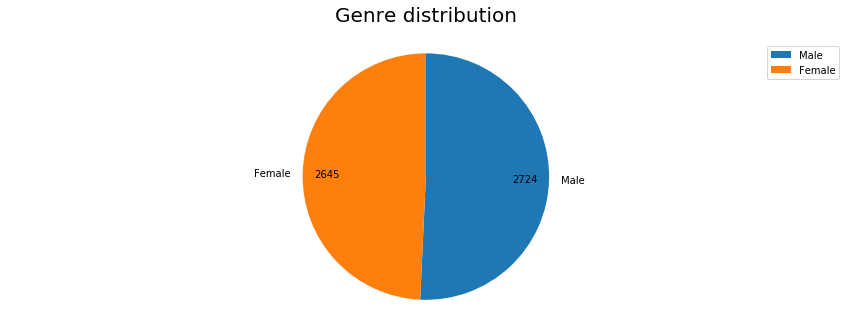

In [9]:
client_data_genre_copy = client_data.copy()

ser = client_data_genre_copy.groupby('genre')['genre'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=["Male","Female"], startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Genre distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

In [10]:
# build train dataset

train_data = loan_train
train_data = pd.merge(train_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
train_data = pd.merge(train_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
train_data = pd.merge(train_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
train_data = pd.merge(train_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
train_data = pd.merge(train_data, card_train, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
train_data = pd.merge(train_data, client_data, on = 'client_id', suffixes = ('', '_client'))
train_data = train_data.drop(['district_id_client'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 40 columns):
loan_id                                             24494 non-null float64
account_id                                          24494 non-null float64
date                                                24494 non-null float64
amount                                              24494 non-null float64
duration                                            24494 non-null float64
payments                                            24494 non-null float64
status                                              24494 non-null float64
trans_id                                            24494 non-null float64
date_trans                                          24494 non-null float64
type                                                24494 non-null object
operation                                           20163 non-null object
amount_trans                                        24494 non-null f

In [11]:
train_data.head()

loan_id  account_id      date   amount  duration  payments  status  \
0   5314.0      1787.0  930705.0  96396.0      12.0    8033.0    -1.0   
1   5314.0      1787.0  930705.0  96396.0      12.0    8033.0    -1.0   
2   5314.0      1787.0  930705.0  96396.0      12.0    8033.0    -1.0   
3   5314.0      1787.0  930705.0  96396.0      12.0    8033.0    -1.0   
4   6903.0      9337.0  940604.0  52128.0      24.0    2172.0     1.0   

    trans_id  date_trans    type  ... no. of commited crimes '95  \
0   523621.0    930322.0  credit  ...                     2985.0   
1   524054.0    930421.0  credit  ...                     2985.0   
2   524055.0    930521.0  credit  ...                     2985.0   
3   524056.0    930620.0  credit  ...                     2985.0   
4  2820215.0    930913.0  credit  ...                     2985.0   

   no. of commited crimes '96  disp_id client_id card_id  type_card  issued  \
0                      2804.0     2166    2166.0     NaN        NaN     NaN   
1                      2804.0     2166    2166.0     NaN        NaN     NaN   
2                      2804.0     2166    2166.0     NaN        NaN     NaN   
3                      2804.0     2166    2166.0     NaN        NaN     NaN   
4                      2804.0    11189   11497.0     NaN        NaN     NaN   

  birth_number  age  genre  
0     47-07-22   48      0  
1     47-07-22   48      0  
2     47-07-22   48      0  
3     47-07-22   48      0  
4     59-07-17   36      0  

[5 rows x 40 columns]

In [12]:
# build test dataset

test_data = loan_test
test_data = pd.merge(test_data, trans_test, on = 'account_id', suffixes = ('', '_trans'))
test_data = pd.merge(test_data, account_data, on = 'account_id', suffixes = ('', '_account'))
test_data = pd.merge(test_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
test_data = pd.merge(test_data, disp_owners, on = 'account_id', suffixes = ('', '_disp'))
test_data = pd.merge(test_data, card_test, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
test_data = pd.merge(test_data, client_data, on = 'client_id', suffixes = ('', '_client'))
test_data = test_data.drop(['district_id_client'], axis=1)
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30200 entries, 0 to 30199
Data columns (total 40 columns):
loan_id                                             30200 non-null int64
account_id                                          30200 non-null int64
date                                                30200 non-null int64
amount                                              30200 non-null int64
duration                                            30200 non-null int64
payments                                            30200 non-null int64
status                                              0 non-null float64
trans_id                                            30200 non-null int64
date_trans                                          30200 non-null int64
type                                                30200 non-null object
operation                                           25070 non-null object
amount_trans                                        30200 non-null float64
balance      

In [13]:
test_data.head()

loan_id  account_id    date  amount  duration  payments  status  trans_id  \
0     5895        4473  970103   93960        60      1566     NaN   1309867   
1     5895        4473  970103   93960        60      1566     NaN   1309878   
2     5895        4473  970103   93960        60      1566     NaN   1310161   
3     5895        4473  970103   93960        60      1566     NaN   3664951   
4     5895        4473  970103   93960        60      1566     NaN   1309879   

   date_trans    type  ... no. of commited crimes '95  \
0      951009  credit  ...                     2080.0   
1      951107  credit  ...                     2080.0   
2      951108  credit  ...                     2080.0   
3      951130  credit  ...                     2080.0   
4      951207  credit  ...                     2080.0   

   no. of commited crimes '96  disp_id client_id card_id  type_card  issued  \
0                        2122     5395      5395     NaN        NaN     NaN   
1                        2122     5395      5395     NaN        NaN     NaN   
2                        2122     5395      5395     NaN        NaN     NaN   
3                        2122     5395      5395     NaN        NaN     NaN   
4                        2122     5395      5395     NaN        NaN     NaN   

  birth_number  age  genre  
0     62-06-01   33      1  
1     62-06-01   33      1  
2     62-06-01   33      1  
3     62-06-01   33      1  
4     62-06-01   33      1  

[5 rows x 40 columns]

Now we can create an age column where we will keep the age of the client at the time of the requested loan.

In [14]:
loan_dates = train_data['date']

loan_dates = [str(int(x))[:2] + "-" + str(int(x))[2:4] + "-" + str(int(x))[4:] for x in loan_dates]

birth_dates = train_data['birth_number']

#print(sorted(birth_dates))

#print(len(birth_dates))
#print(sorted(birth_dates))

from datetime import date
 
def calculateAge(birthDate, loanDate):
    loan = loanDate.split("-")
    loan_date = date(int(loan[0]), int(loan[1]), int(loan[2]))
    birth = birthDate.split("-")
    
    birth_date = date(int(birth[0]), int(birth[1]), int(birth[2]))
    return (int((loan_date-birth_date).days/365))

age_list = [calculateAge(birth_dates[n],loan_dates[n]) for n in range(0,len(birth_dates))]

train_data["age"] = age_list

print(train_data["age"])

0        45
1        45
2        45
3        45
4        34
5        34
6        34
7        34
8        34
9        34
10       34
11       34
12       34
13       34
14       34
15       34
16       34
17       34
18       34
19       34
20       34
21       34
22       34
23       34
24       34
25       34
26       34
27       34
28       34
29       34
         ..
24464    33
24465    33
24466    33
24467    33
24468    33
24469    33
24470    33
24471    33
24472    33
24473    33
24474    33
24475    33
24476    33
24477    33
24478    33
24479    33
24480    33
24481    33
24482    33
24483    33
24484    33
24485    33
24486    33
24487    33
24488    33
24489    33
24490    33
24491    33
24492    33
24493    33
Name: age, Length: 24494, dtype: int64


Now let's do the same for the test data

In [15]:
loan_dates = test_data['date']

loan_dates = [str(int(x))[:2] + "-" + str(int(x))[2:4] + "-" + str(int(x))[4:] for x in loan_dates]

birth_dates = test_data['birth_number']

age_list = [calculateAge(birth_dates[n],loan_dates[n]) for n in range(0,len(test_data))]

test_data["age"] = age_list

print(test_data["age"])

0        34
1        34
2        34
3        34
4        34
5        34
6        34
7        34
8        34
9        34
10       34
11       34
12       34
13       34
14       34
15       34
16       34
17       34
18       34
19       34
20       34
21       34
22       34
23       34
24       34
25       34
26       34
27       34
28       34
29       34
         ..
30170    46
30171    46
30172    46
30173    46
30174    46
30175    46
30176    46
30177    46
30178    46
30179    46
30180    46
30181    46
30182    46
30183    46
30184    46
30185    46
30186    46
30187    46
30188    46
30189    46
30190    46
30191    46
30192    46
30193    46
30194    46
30195    46
30196    46
30197    46
30198    46
30199    46
Name: age, Length: 30200, dtype: int64


In [16]:
train_data.drop(['birth_number'], axis=1, inplace=True)
test_data.drop(['birth_number'], axis=1, inplace=True)

<Figure size 432x288 with 0 Axes>

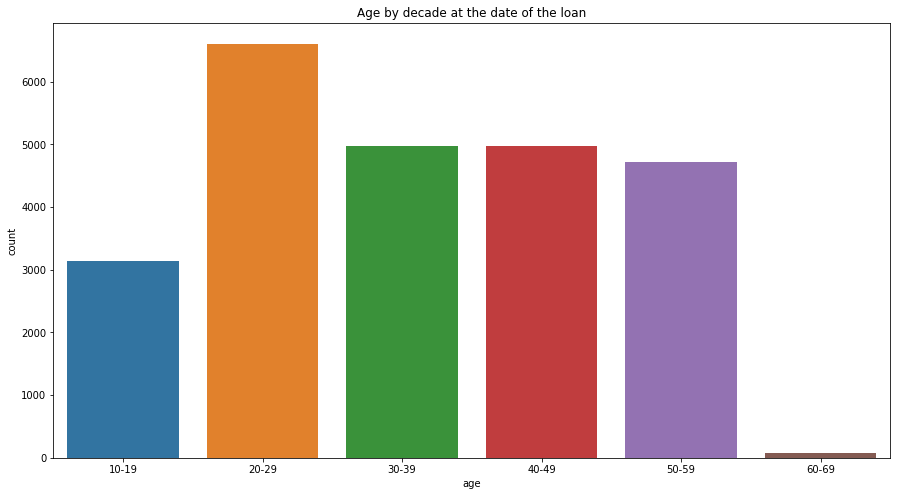

In [17]:
def get_decade(year):
    year_int = int(year)
    string = str(year_int//10) + "0-" + str(year_int//10) + "9"
    return string

train_data_copy = train_data.copy()

train_data_copy = train_data_copy.astype({'age': str})

train_data_copy['age'] = train_data_copy['age'].apply(lambda x: get_decade(x))

train_data_copy = train_data_copy.sort_values('age')

fig = plt.figure()
plt.figure(figsize=(15,8))
plt.title("Age by decade at the date of the loan")
ax = sb.countplot(x="age", data=train_data_copy)
plt.show()

Now we can see the months when the accounts were created.

<Figure size 432x288 with 0 Axes>

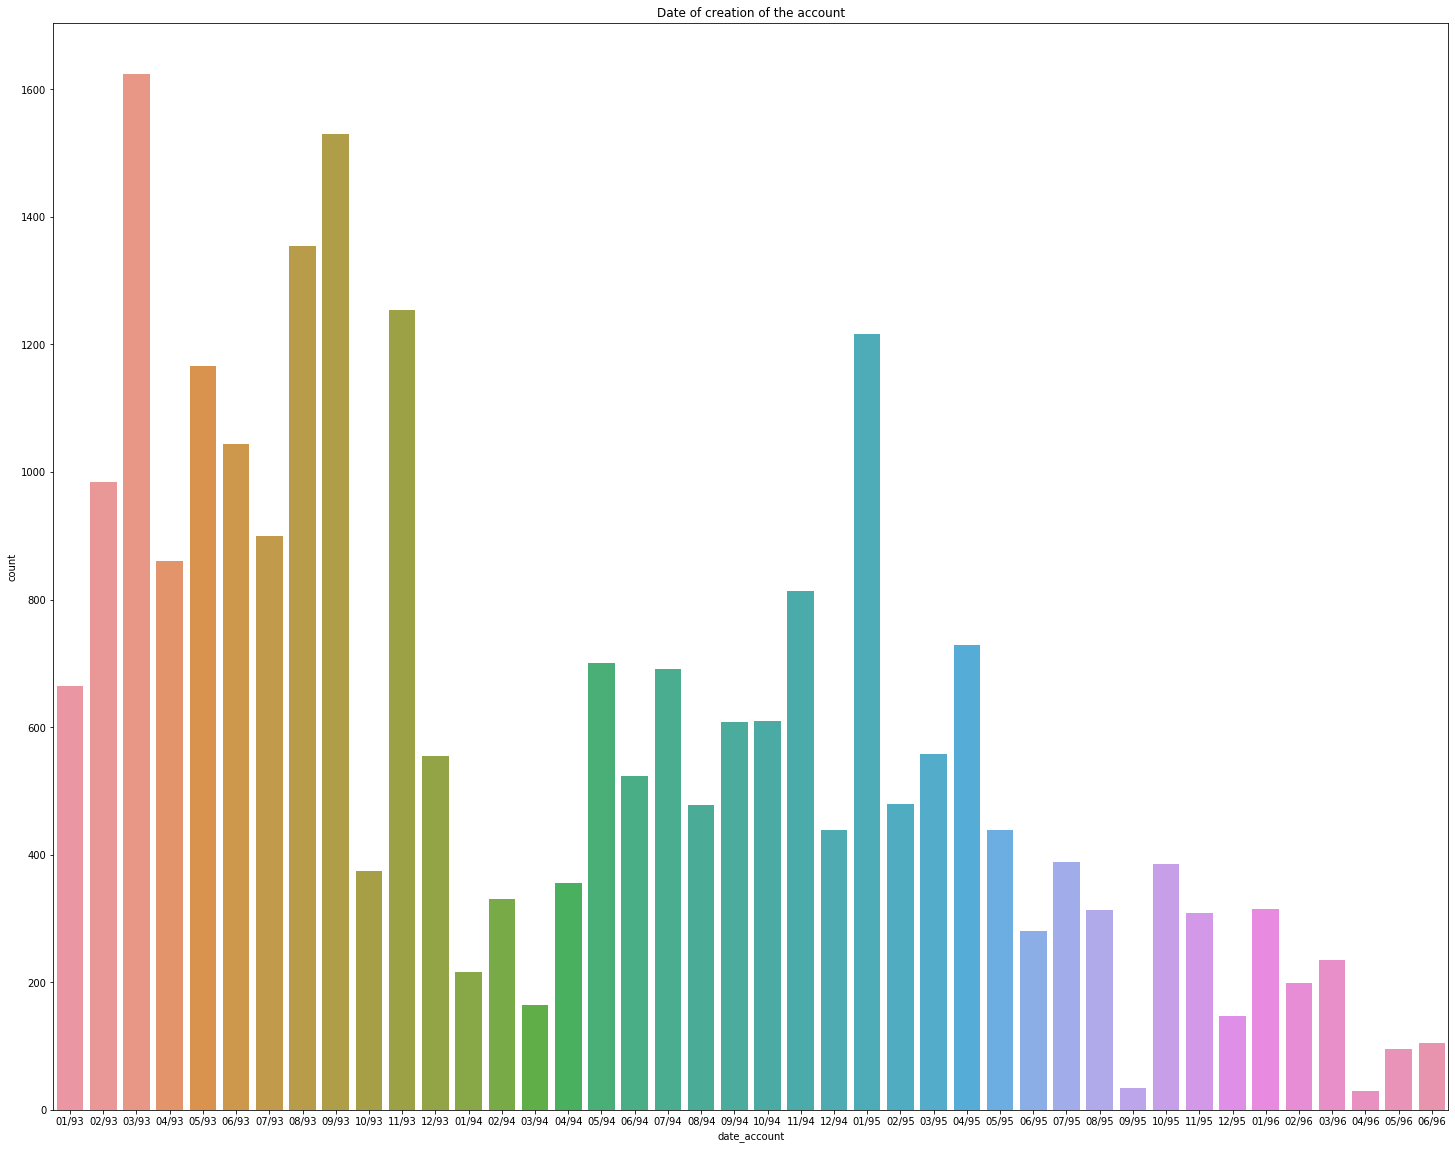

In [18]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date_account')
train_data_copy = train_data_copy.astype({'date_account': str})

train_data_copy['date_account'] = train_data_copy['date_account'].apply(lambda x: get_month(x[0:4]))

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Date of creation of the account")
ax = sb.countplot(x="date_account", data=train_data_copy)
plt.show()

We can also see the month and year of when the loans were created and their relation to the number of successful loans.

<Figure size 432x288 with 0 Axes>

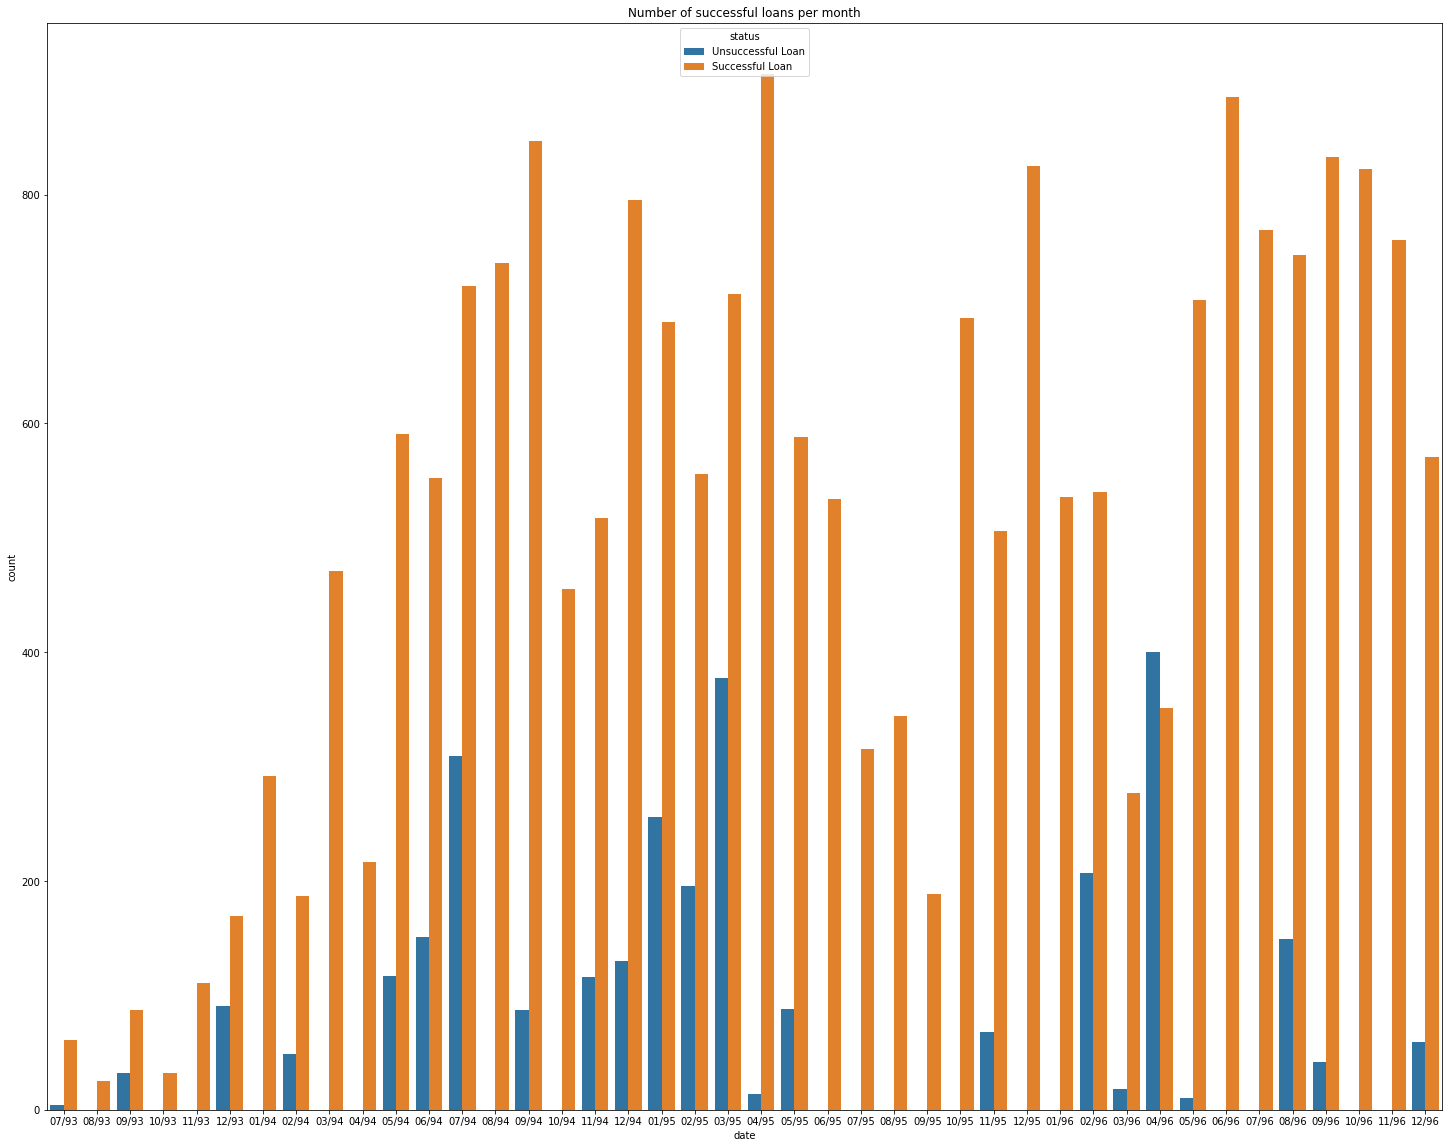

In [19]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date')
train_data_copy = train_data_copy.astype({'date': str})

train_data_copy['date'] = train_data_copy['date'].apply(lambda x: get_month(x[0:4]))

train_data_copy = train_data_copy.astype({'status': str})
train_data_copy['status'] = train_data_copy['status'].replace(['1.0','-1.0'],['Successful Loan','Unsuccessful Loan'])

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Number of successful loans per month")
ax = sb.countplot(x ='date', hue = "status", data = train_data_copy)
plt.show()

As follows we can see the months when the most transfers were taken.

<Figure size 432x288 with 0 Axes>

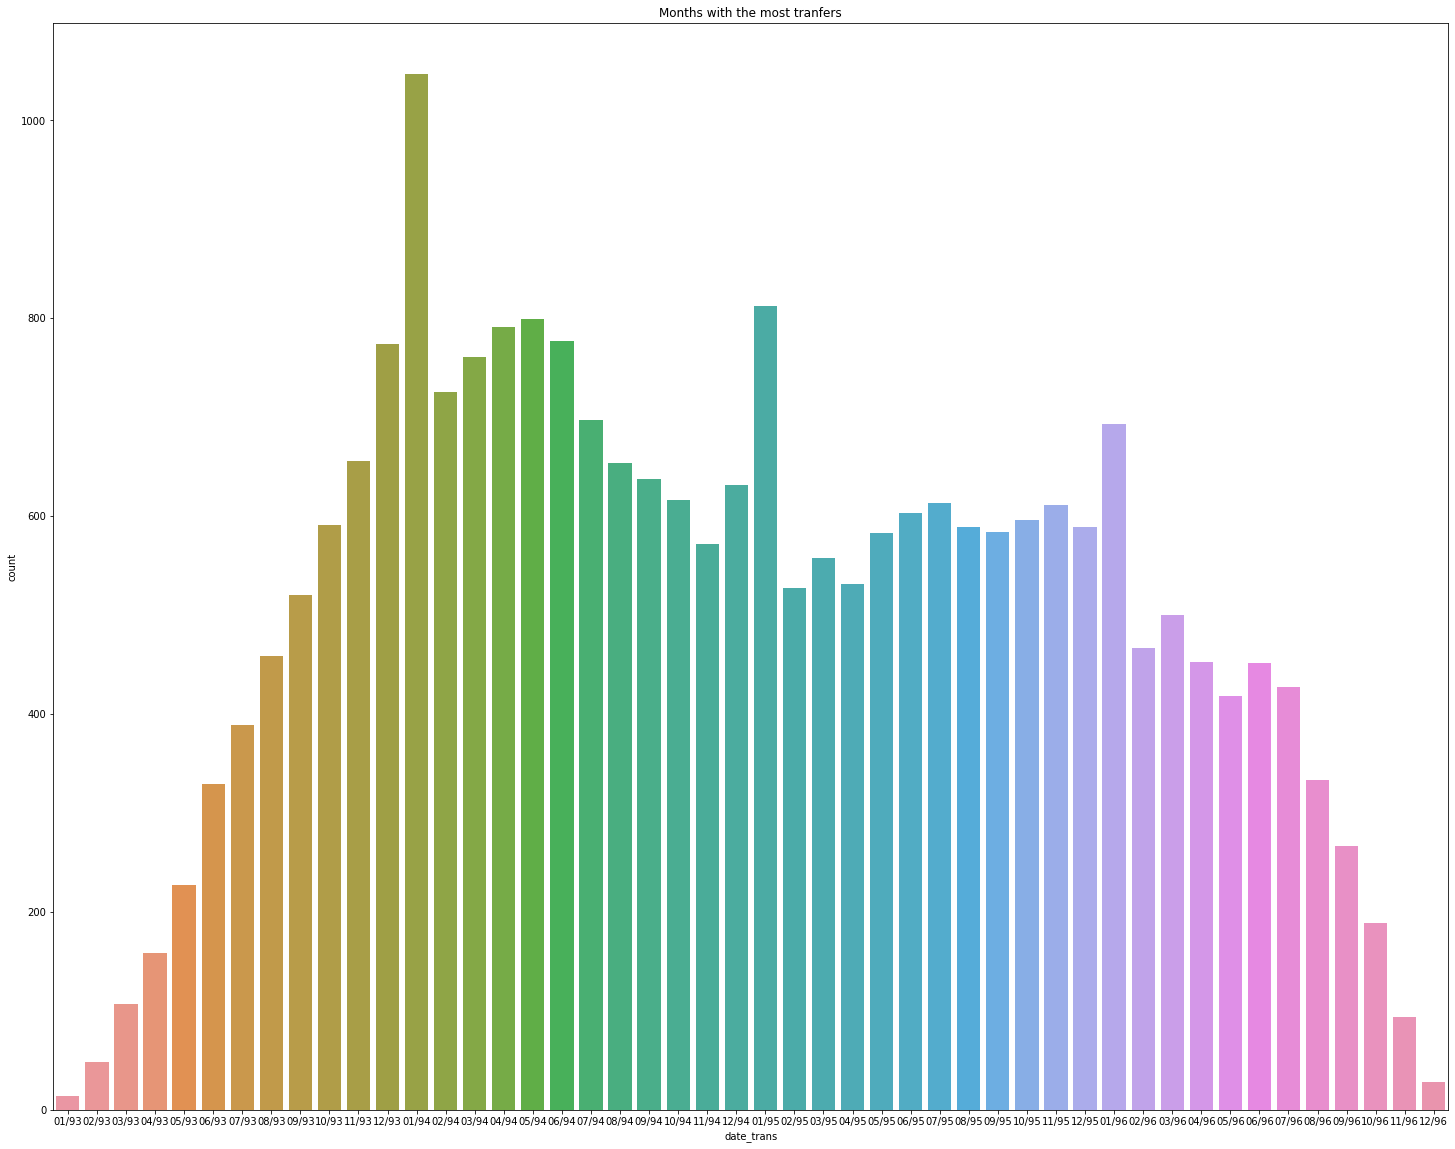

In [20]:
def get_month(year):
    string = year[2:4] + "/" + year[0:2]
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.sort_values('date_trans')
train_data_copy = train_data_copy.astype({'date_trans': str})

train_data_copy['date_trans'] = train_data_copy['date_trans'].apply(lambda x: get_month(x[0:4]))

fig = plt.figure()
plt.figure(figsize=(25,20))
plt.title("Months with the most tranfers")
ax = sb.countplot(x="date_trans", data=train_data_copy)
plt.show()

In [21]:
# Remove all dates from data, because only the number doesn't make sense. Probably transform it to age?
train_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)
test_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)

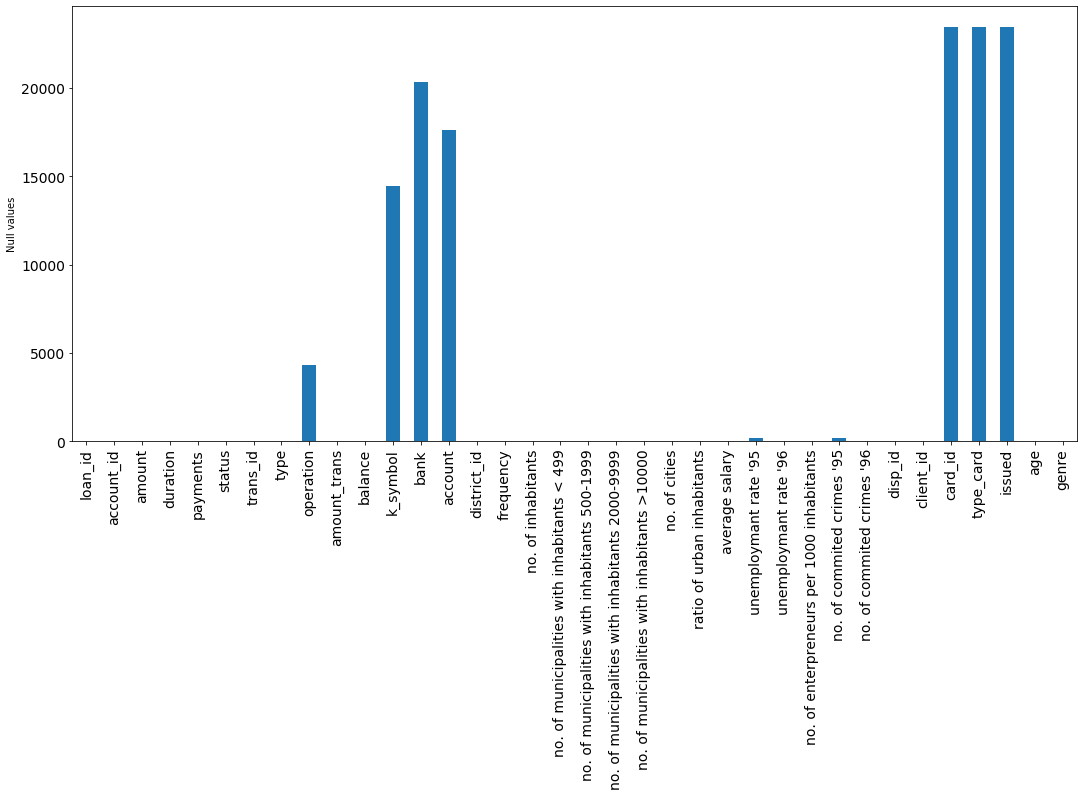

In [22]:
# Null values for each attribute
train_data.isnull().sum().plot(kind='bar', figsize=(18,8), fontsize=14,);
plt.ylabel('Null values');

In [23]:
print('Null values unemploymant rate in \'95:' + str(district_data['unemploymant rate \'95'].isnull().sum()))
print()
print('Null values no. of commited crimes \'95 :' + str(district_data['no. of commited crimes \'95'].isnull().sum()))
print()

Null values unemploymant rate in '95:1

Null values no. of commited crimes '95 :1



In [24]:
train_data_copy = train_data.copy()

train_data_copy = train_data_copy.loc[:, train_data_copy.columns.intersection(['type','operation'])]
train_data_copy["operation"] = train_data_copy["operation"].fillna('NaN')

train_data_copy.sort_values("operation")

print(train_data_copy["type"].unique())
print(train_data_copy["operation"].unique())

['credit' 'withdrawal' 'withdrawal in cash']
['credit in cash' 'NaN' 'withdrawal in cash' 'remittance to another bank'
 'collection from another bank' 'credit card withdrawal']


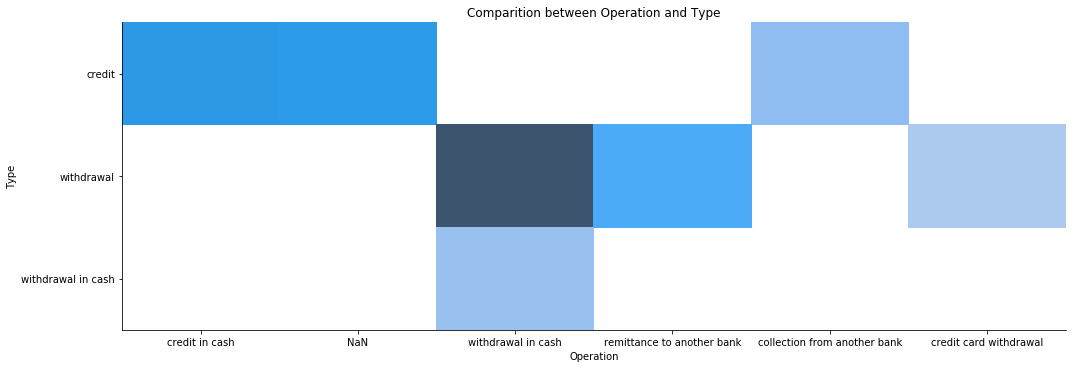

In [25]:
sb.displot(train_data_copy,x='operation', y='type', aspect=3)
plt.xlabel('Operation');
plt.ylabel('Type');
plt.title("Comparition between Operation and Type")
plt.show()

As we can see all the rows with operation *credit in cash* and *collection from another bank* are of type credit. All the *withdrawal in cash*, *remittance to another bank* and *credit cash withdrawal* operations are of the type *withdraw* or *withdrawal with cash* (in the case of the homonymous operation)

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


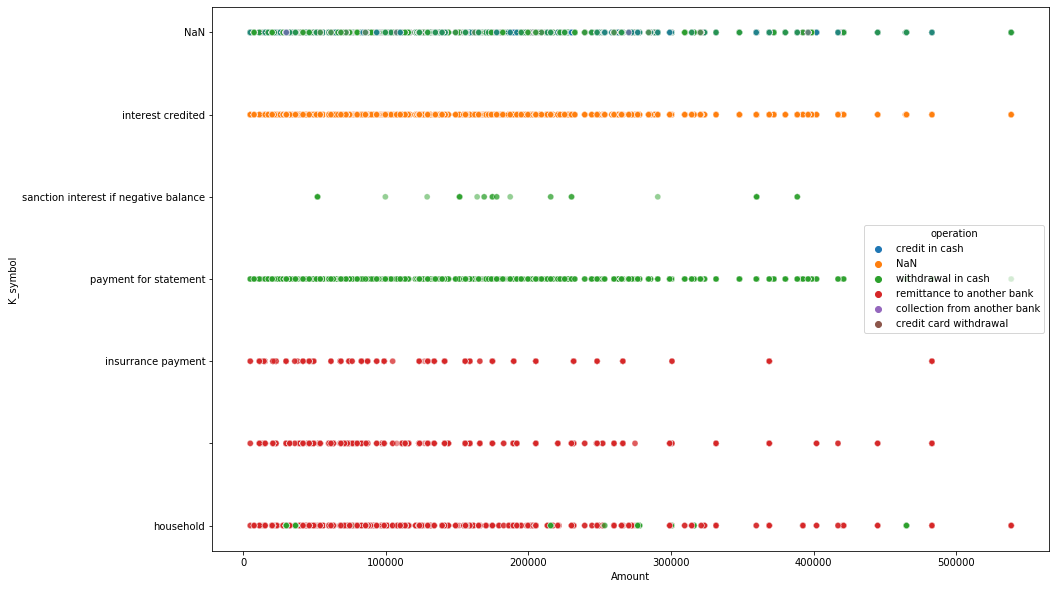

In [26]:
plt.figure(figsize=(15,10))

train_data_copy = train_data.copy()
train_data_copy["operation"] = train_data_copy["operation"].fillna('NaN')
train_data_copy["k_symbol"] = train_data_copy["k_symbol"].fillna('NaN')

sb.scatterplot(train_data_copy["amount"],train_data_copy["k_symbol"],train_data_copy["operation"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Amount")
plt.ylabel("K_symbol")
plt.show()

As we can see the great majority of the k_symbol types are directly related to a certain operation type

[back](#index)
#### District Data <a id="district-data"></a>

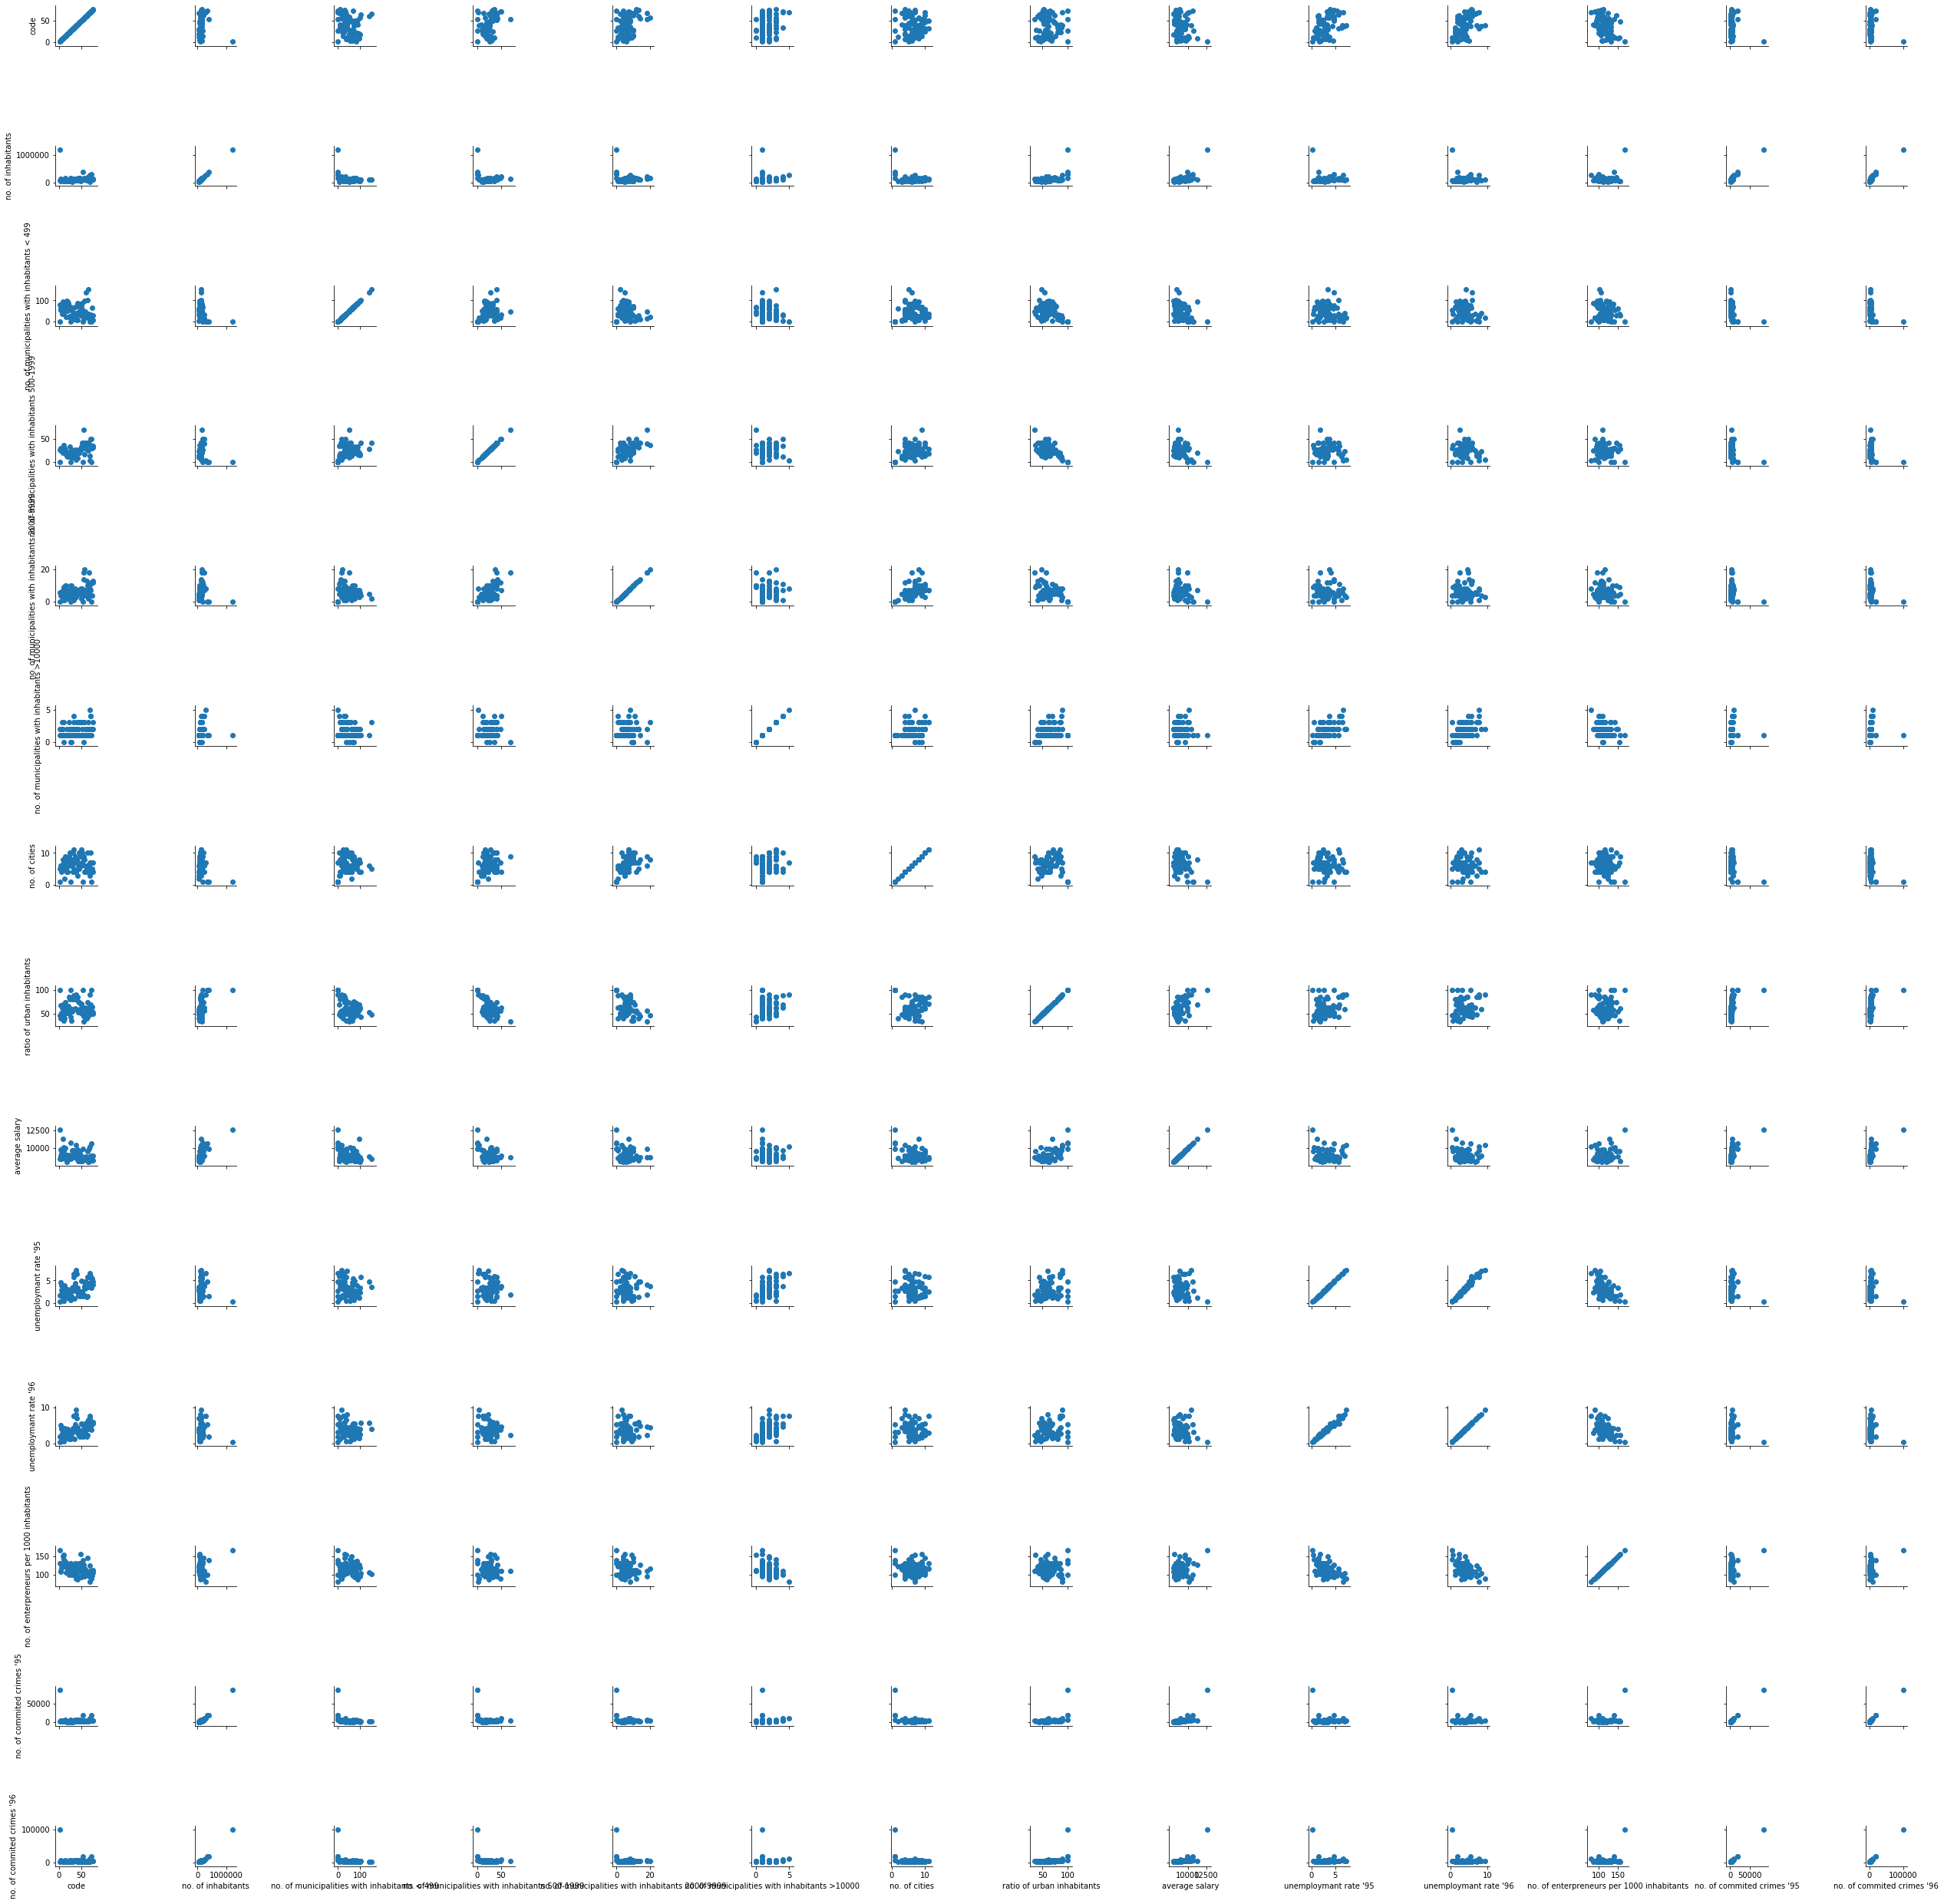

In [27]:
district_scatter_plot = sb.PairGrid(district_data)
district_scatter_plot.map(plt.scatter)

C:\Users\pedro\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\pedro\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 4., 13., 10., 13., 15.,  5.,  6.,  4.,  4.,  2.]),
 array([0.29 , 0.995, 1.7  , 2.405, 3.11 , 3.815, 4.52 , 5.225, 5.93 ,
        6.635, 7.34 ]),
 <a list of 10 Patch objects>)

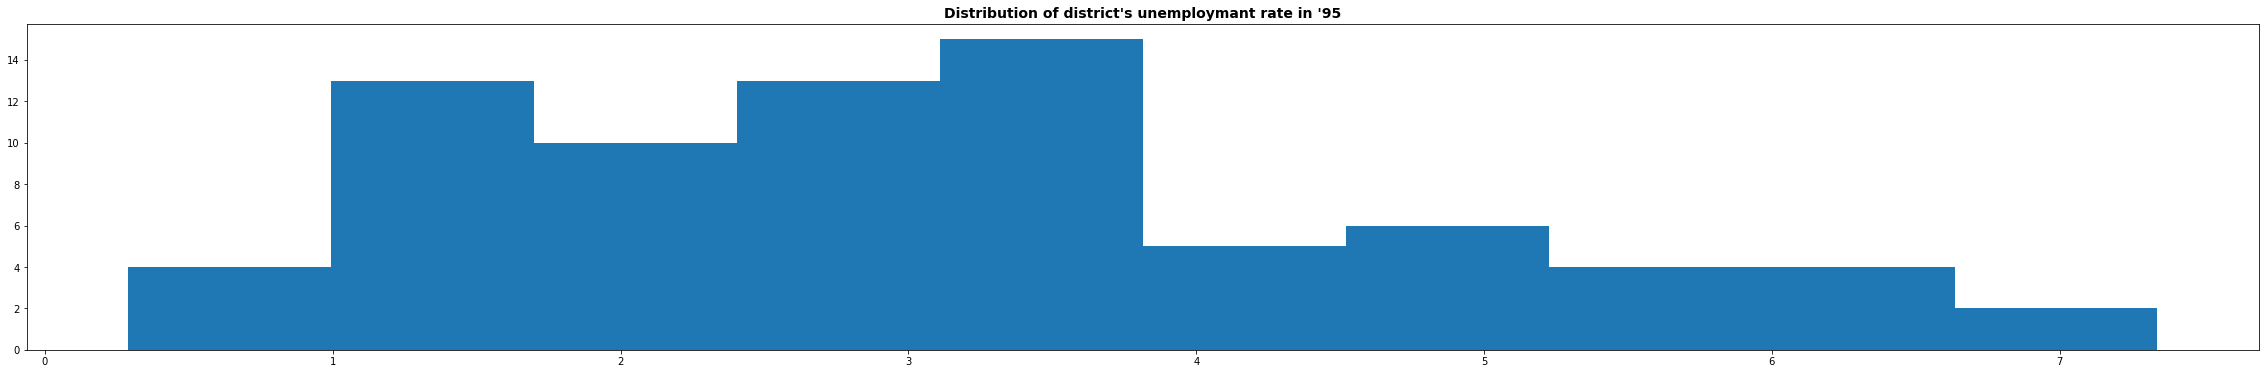

In [28]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s unemploymant rate in \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['unemploymant rate \'95'])

(array([71.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

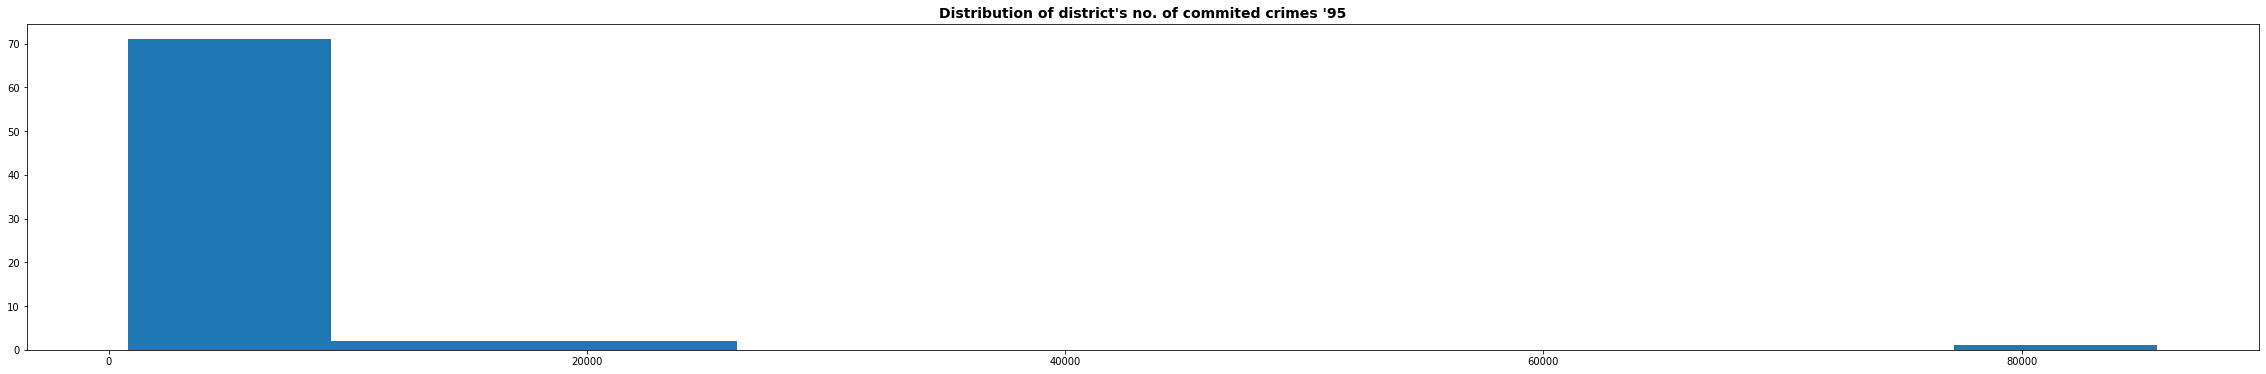

In [29]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s no. of commited crimes \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['no. of commited crimes \'95'])

In [30]:
# Fill null values in district's unemploymant rate in '95 and district's no. of commited crimes '95
# See if it is better to use median or mean 

train_data['unemploymant rate \'95'].fillna(train_data['unemploymant rate \'95'].median(), inplace=True)

train_data['no. of commited crimes \'95'].fillna(train_data['no. of commited crimes \'95'].mean(), inplace=True)

test_data['unemploymant rate \'95'].fillna(test_data['unemploymant rate \'95'].median(), inplace=True)

test_data['no. of commited crimes \'95'].fillna(test_data['no. of commited crimes \'95'].mean(), inplace=True)

In [31]:
print(train_data.operation.value_counts())
print('Null values: ' + str(train_data.operation.isnull().sum()))
print()
print(train_data.k_symbol.value_counts())
print('Null values: ' + str(train_data.k_symbol.isnull().sum()))
print()
print(train_data.bank.value_counts())
print('Null values: ' + str(train_data.bank.isnull().sum()))
print()
print(train_data.type_card.value_counts())
print('Null values: ' + str(train_data.type_card.isnull().sum()))
print()
print(train_data.type.value_counts())
print('Null values: ' + str(train_data.type.isnull().sum()))
print()

withdrawal in cash              11462
credit in cash                   4506
remittance to another bank       3033
collection from another bank     1139
credit card withdrawal             23
Name: operation, dtype: int64
Null values: 4331

interest credited                        4331
payment for statement                    2528
household                                1724
                                         1001
insurrance payment                        419
sanction interest if negative balance      38
Name: k_symbol, dtype: int64
Null values: 14453

EF    449
YZ    379
ST    375
AB    352
IJ    341
KL    330
GH    328
QR    320
CD    294
UV    287
OP    283
WX    222
MN    212
Name: bank, dtype: int64
Null values: 20322

classic    862
gold        99
junior      77
Name: type_card, dtype: int64
Null values: 23456

withdrawal            13730
credit                 9976
withdrawal in cash      788
Name: type, dtype: int64
Null values: 0



In [32]:
operations_null = train_data[train_data['operation'].isnull()]
operations_null.head()

loan_id  account_id   amount  duration  payments  status   trans_id  \
7    6903.0      9337.0  52128.0      24.0    2172.0     1.0  3682686.0   
8    6903.0      9337.0  52128.0      24.0    2172.0     1.0  3456558.0   
9    6903.0      9337.0  52128.0      24.0    2172.0     1.0  3510168.0   
11   6903.0      9337.0  52128.0      24.0    2172.0     1.0  3682687.0   
12   6903.0      9337.0  52128.0      24.0    2172.0     1.0  3456559.0   

      type operation  amount_trans  ...  \
7   credit       NaN          44.1  ...   
8   credit       NaN          44.1  ...   
9   credit       NaN          38.7  ...   
11  credit       NaN         161.9  ...   
12  credit       NaN         162.6  ...   

    no. of enterpreneurs per 1000 inhabitants no. of commited crimes '95  \
7                                       100.0                     2985.0   
8                                       100.0                     2985.0   
9                                       100.0                     2985.0   
11                                      100.0                     2985.0   
12                                      100.0                     2985.0   

   no. of commited crimes '96  disp_id  client_id card_id  type_card  issued  \
7                      2804.0    11189    11497.0     NaN        NaN     NaN   
8                      2804.0    11189    11497.0     NaN        NaN     NaN   
9                      2804.0    11189    11497.0     NaN        NaN     NaN   
11                     2804.0    11189    11497.0     NaN        NaN     NaN   
12                     2804.0    11189    11497.0     NaN        NaN     NaN   

    age  genre  
7    34      0  
8    34      0  
9    34      0  
11   34      0  
12   34      0  

[5 rows x 36 columns]

In [33]:
operations_null.k_symbol.value_counts()

interest credited    4331
Name: k_symbol, dtype: int64

All rows that have 'operation' column with null value have 'interested credited' in 'k_symbol' column.

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 36 columns):
loan_id                                             24494 non-null float64
account_id                                          24494 non-null float64
amount                                              24494 non-null float64
duration                                            24494 non-null float64
payments                                            24494 non-null float64
status                                              24494 non-null float64
trans_id                                            24494 non-null float64
type                                                24494 non-null object
operation                                           20163 non-null object
amount_trans                                        24494 non-null float64
balance                                             24494 non-null float64
k_symbol                                            10041 non-null o

Representation of the Card Type, with NaN values

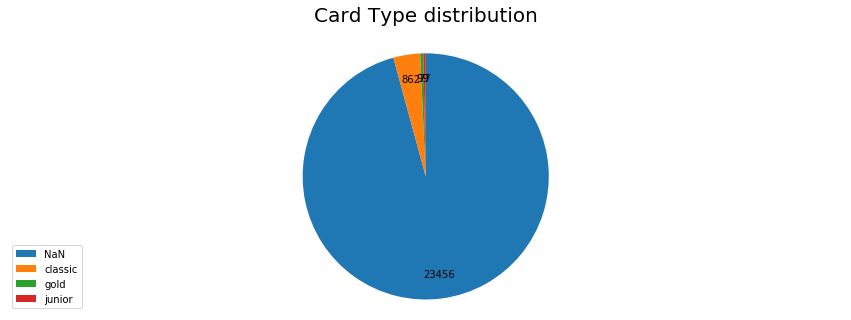

In [35]:
train_data_copy = train_data.copy()

train_data_copy['type_card'] = train_data_copy['type_card'].fillna("NaN")

ser = train_data_copy.groupby('type_card')['type_card'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1,2,3]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=['','','',''], startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend(loc=3, labels=ser.index)
plt.axis('equal')
plt.title('Card Type distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

Representation of the Card Type, without NaN values

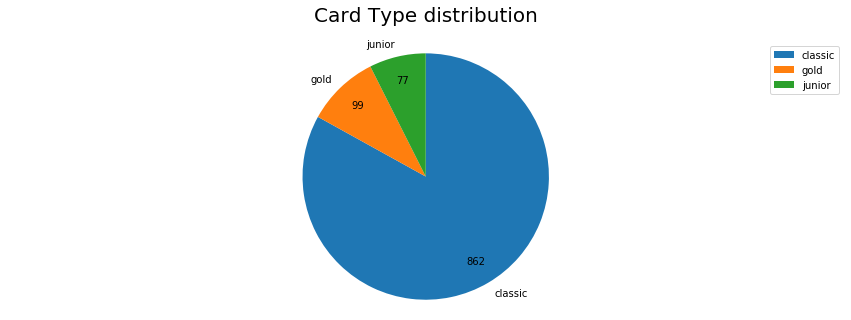

In [36]:
train_data_copy = train_data.copy()

ser = train_data_copy.groupby('type_card')['type_card'].count()
ser = ser.sort_values(ascending=False)
ser = ser.iloc[[0,1,2]]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.pie(ser.values, labels=ser.index, startangle=90, autopct=lambda x:int(x/100.*ser.sum()+0.1), pctdistance=0.8, counterclock=False)
ax.legend()
plt.axis('equal')
plt.title('Card Type distribution', y=1.05, fontsize=20)
fig.set_size_inches(15, 5)

[back](#index)
#### Dataset Managing <a id="dataset"></a>

In [37]:
# needs to be checked
option = 1
if option ==1:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
#replaced withdrawal in cash with only withdrawal
elif option==2:
    train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
    train_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
    test_data.replace('withdrawal in cash', 'withdrawal', inplace=True)
#filled nulls from operation with k_symbol
elif option==3:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
#joined operation and k_symbol
elif option==4:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data['k_symbol'].fillna(train_data['operation'], inplace=True)
    test_data['k_symbol'].fillna(test_data['operation'], inplace=True)
    train_data['operation']=train_data['operation'] + ' ' + train_data['k_symbol']
    test_data['operation']=test_data['operation'] + ' ' + test_data['k_symbol']
    train_data["operation"] = train_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    test_data["operation"] = test_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    train_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued'], axis=1, inplace=True)
#joined operation and k_symbol and dropped type
elif option==5:
    train_data['operation'].fillna(train_data['k_symbol'], inplace=True)
    test_data['operation'].fillna(test_data['k_symbol'], inplace=True)
    train_data['k_symbol'].fillna(train_data['operation'], inplace=True)
    test_data['k_symbol'].fillna(test_data['operation'], inplace=True)
    train_data['operation']=train_data['operation'] + ' ' + train_data['k_symbol']
    test_data['operation']=test_data['operation'] + ' ' + test_data['k_symbol']
    train_data["operation"] = train_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    test_data["operation"] = test_data["operation"].apply(lambda x: ' '.join(pd.unique(x.split())))
    train_data.drop(['bank', 'k_symbol', 'account', 'issued', 'type'], axis=1, inplace=True)
    test_data.drop(['bank', 'k_symbol', 'account', 'issued', 'type'], axis=1, inplace=True)
    

In [38]:
train_data = pd.get_dummies(train_data, columns=['frequency'], dtype=bool)
test_data = pd.get_dummies(test_data, columns=['frequency'], dtype=bool)

train_data = pd.get_dummies(train_data, columns=['type_card'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_card'], dtype = bool)

# train_data = pd.get_dummies(train_data, columns=['type_disp'], dtype = bool)
# test_data = pd.get_dummies(test_data, columns=['type_disp'], dtype = bool)

if option != 5:
    train_data = pd.get_dummies(train_data, columns=['type'], dtype = bool)
    test_data = pd.get_dummies(test_data, columns=['type'], dtype = bool)

if option == 3 or option == 4:
    train_data = pd.get_dummies(train_data, columns=['operation'], dtype = bool)
    test_data = pd.get_dummies(test_data, columns=['operation'], dtype = bool)

test_data = test_data.drop_duplicates(subset=['loan_id'], keep='first')

#train_data = pd.get_dummies(train_data)
#test_data = pd.get_dummies(test_data)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 37 columns):
loan_id                                             24494 non-null float64
account_id                                          24494 non-null float64
amount                                              24494 non-null float64
duration                                            24494 non-null float64
payments                                            24494 non-null float64
status                                              24494 non-null float64
trans_id                                            24494 non-null float64
amount_trans                                        24494 non-null float64
balance                                             24494 non-null float64
district_id                                         24494 non-null float64
no. of inhabitants                                  24494 non-null float64
no. of municipalities with inhabitants < 499        24494 non-null

In [39]:
train_data.head()

loan_id  account_id   amount  duration  payments  status   trans_id  \
0   5314.0      1787.0  96396.0      12.0    8033.0    -1.0   523621.0   
1   5314.0      1787.0  96396.0      12.0    8033.0    -1.0   524054.0   
2   5314.0      1787.0  96396.0      12.0    8033.0    -1.0   524055.0   
3   5314.0      1787.0  96396.0      12.0    8033.0    -1.0   524056.0   
4   6903.0      9337.0  52128.0      24.0    2172.0     1.0  2820215.0   

   amount_trans  balance  district_id  ...  genre  \
0        1100.0   1100.0         30.0  ...      0   
1        9900.0  11000.0         30.0  ...      0   
2        5800.0  16800.0         30.0  ...      0   
3        3300.0  20100.0         30.0  ...      0   
4         900.0    900.0         30.0  ...      0   

   frequency_issuance after transaction  frequency_monthly issuance  \
0                                 False                       False   
1                                 False                       False   
2                                 False                       False   
3                                 False                       False   
4                                 False                        True   

   frequency_weekly issuance  type_card_classic  type_card_gold  \
0                       True              False           False   
1                       True              False           False   
2                       True              False           False   
3                       True              False           False   
4                      False              False           False   

   type_card_junior  type_credit  type_withdrawal  type_withdrawal in cash  
0             False         True            False                    False  
1             False         True            False                    False  
2             False         True            False                    False  
3             False         True            False                    False  
4             False         True            False                    False  

[5 rows x 37 columns]

In [40]:
competition_inputs = test_data.drop(columns=["loan_id", "status"])
# test_data = test_data.drop(columns=["status"])
all_ids_comp = test_data['loan_id'].values

#### [back](#index)
#### Data Exploration <a class="anchor" id="data-exploration"></a>

After the previous changes we end up with the following columns to study

In [41]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 30084
Data columns (total 37 columns):
loan_id                                             354 non-null int64
account_id                                          354 non-null int64
amount                                              354 non-null int64
duration                                            354 non-null int64
payments                                            354 non-null int64
status                                              0 non-null float64
trans_id                                            354 non-null int64
amount_trans                                        354 non-null float64
balance                                             354 non-null float64
district_id                                         354 non-null int64
no. of inhabitants                                  354 non-null int64
no. of municipalities with inhabitants < 499        354 non-null int64
no. of municipalities with inhabitant

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


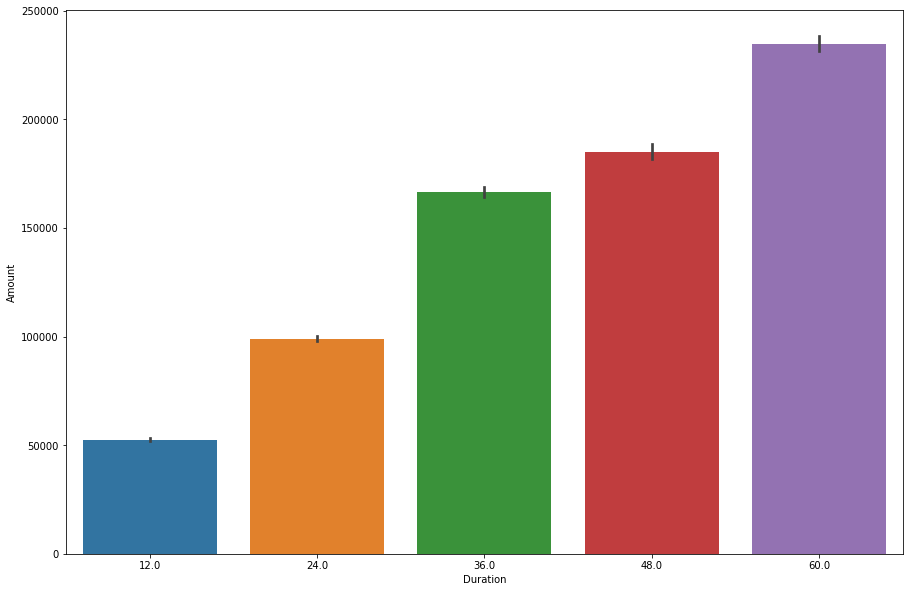

In [42]:
plt.figure(figsize=(15,10))
ax = sb.barplot(train_data["duration"], train_data["amount"])
plt.xlabel('Duration');
plt.ylabel('Amount');
plt.show()

We can clearly see that with bigger loan amounts the time taken to repay them is exponentially higher 

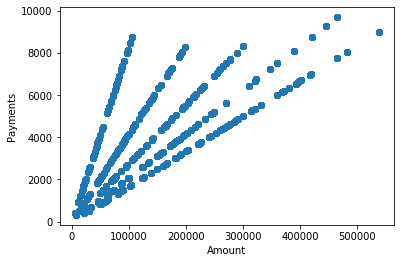

In [43]:
ax = plt.plot(train_data["amount"], train_data["payments"], linestyle='none', marker='o', alpha=0.3)
plt.xlabel('Amount');
plt.ylabel('Payments');
plt.show()

As we can check by the values in the graph, it seems that the number of payments is defined by the bank since the results are very linear and follow a line according to the amount loaned

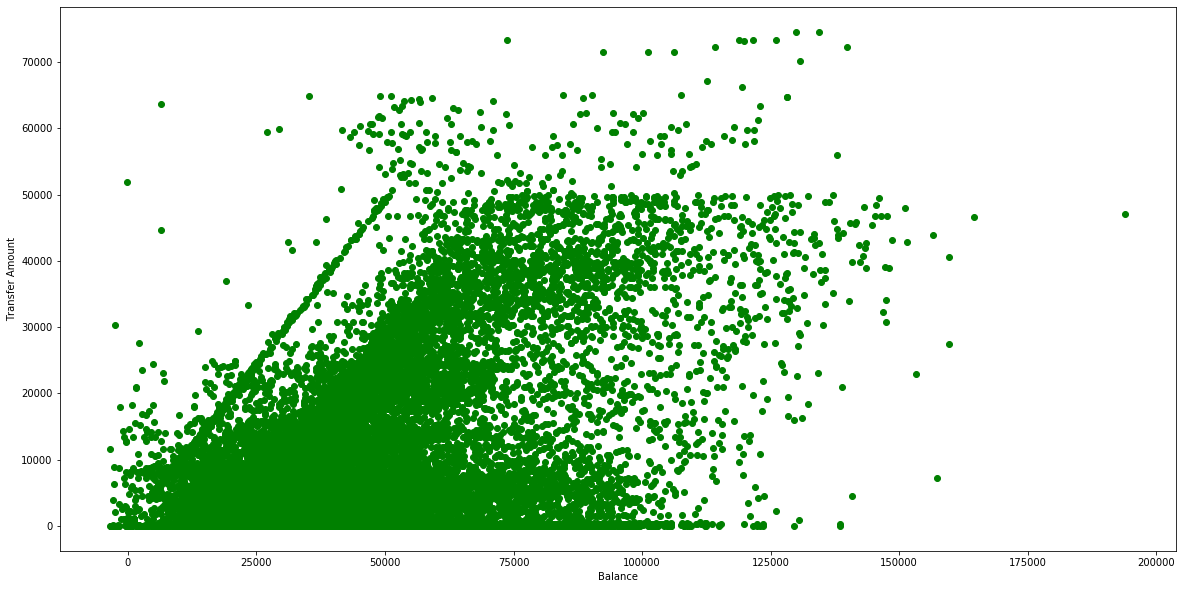

In [44]:
plt.figure(figsize=(20,10))
#ax = sb.barplot(train_data["amount_trans"], train_data["balance"])
plt.plot(train_data["balance"],train_data["amount_trans"], 'o', color='green');
plt.ylabel('Transfer Amount');
plt.xlabel('Balance');
plt.show()

As we can see as the balance increases the transfer amount also increase and is rarely higher than the balance. It can also be seen that a straight continous line exists with gradient 1. This means the amount of some transfers are actually correspondent, or close, to the total amount in the account.

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


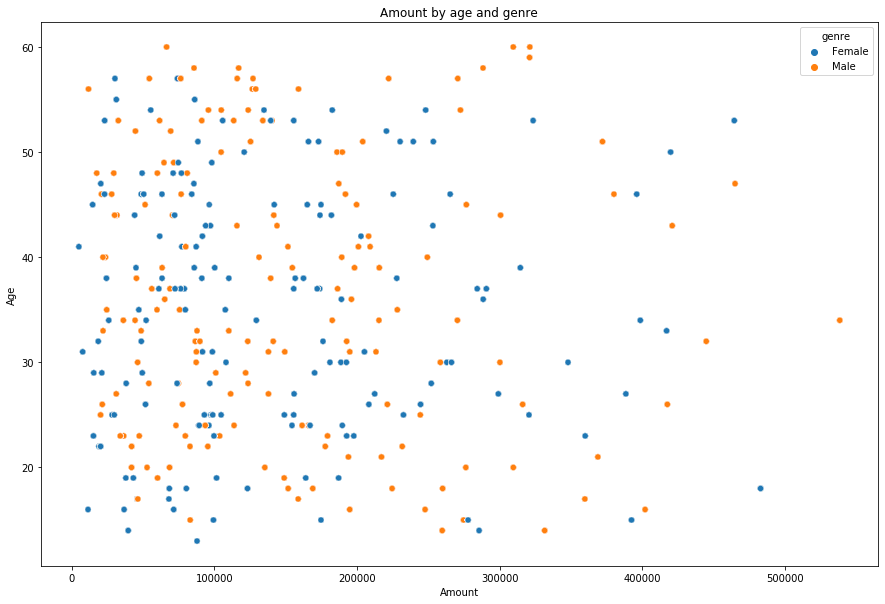

In [45]:
plt.figure(figsize=(15,10))

train_data_names = train_data.copy()
train_data_names["genre"] = train_data_names["genre"].astype(str)
train_data_names["genre"].replace({"1": "Male" , "0": "Female"}, inplace=True)

sb.scatterplot(train_data_names["amount"],train_data_names["age"],train_data_names["genre"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Amount")
plt.ylabel("Age")
plt.title("Amount by age and genre")
plt.show()

C:\Users\pedro\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


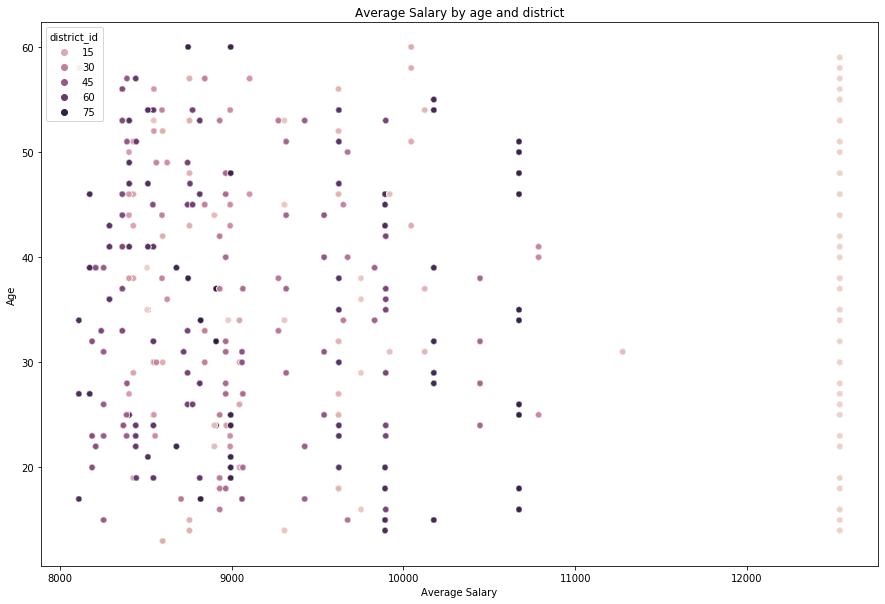

In [46]:
plt.figure(figsize=(15,10))

train_data_names = train_data.copy()
train_data_names["genre"] = train_data_names["genre"].astype(str)
train_data_names["genre"].replace({"1": "Male" , "0": "Female"}, inplace=True)

sb.scatterplot(train_data_names["average salary"],train_data_names["age"],train_data_names["district_id"], alpha=0.5, sizes=(10, 1000), hue="time")
plt.xlabel("Average Salary")
plt.ylabel("Age")
plt.title("Average Salary by age and district")
plt.show()

As follows we can see the average salary by age

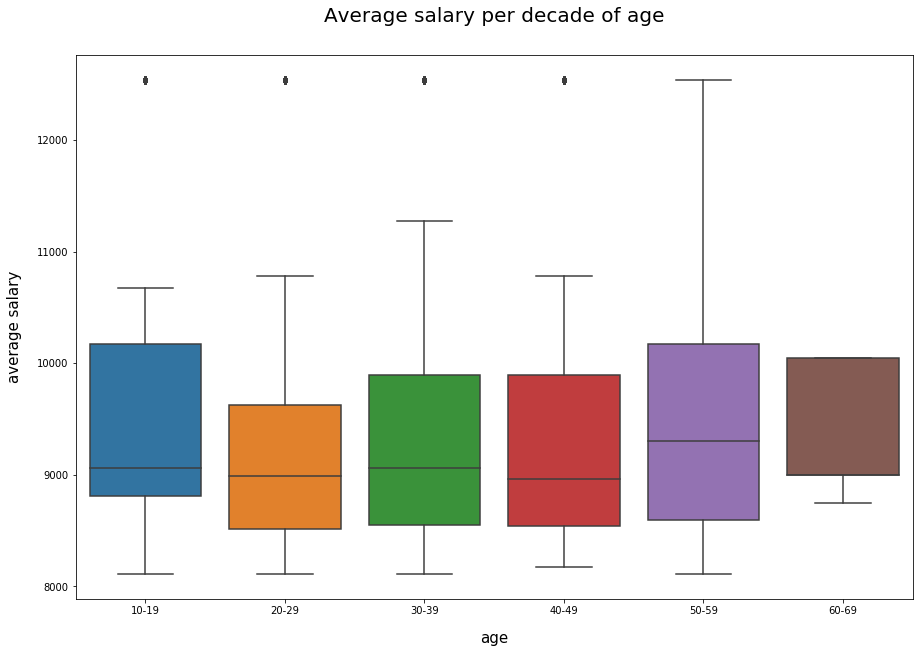

In [47]:
def get_decade(year):
    year_int = int(year)
    string = str(year_int//10) + "0-" + str(year_int//10) + "9"
    return string

train_data_copy = train_data.copy()
train_data_copy = train_data_copy.astype({'age': str})

train_data_copy['age'] = train_data_copy['age'].apply(lambda x: get_decade(x))

train_data_copy = train_data_copy.sort_values('age')
train_data_copy["average salary"] = train_data_copy["average salary"].astype(float)

fig = plt.figure()
sb.boxplot(x=train_data_copy["age"], y=train_data_copy["average salary"])
plt.xlabel('age', y=1.05, fontsize=15, labelpad=15)
plt.ylabel('average salary', x=0.7, fontsize=15, labelpad=15)
plt.title('Average salary per decade of age', y=1.05, fontsize=20)
fig.set_size_inches(15, 10)
plt.show()


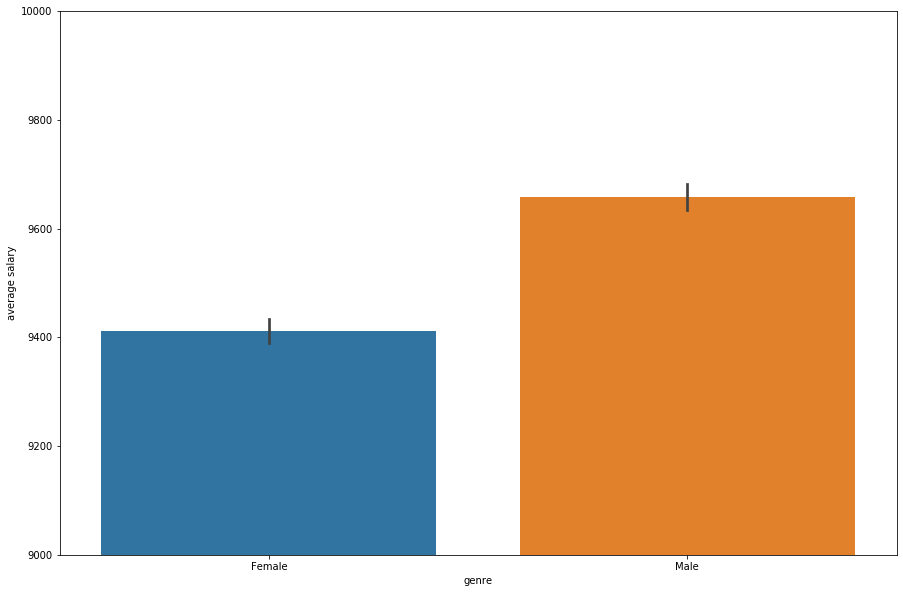

In [48]:
train_data_copy = train_data.copy()
train_data_copy["genre"] = train_data_copy["genre"].astype(str)
train_data_copy["genre"].replace({"0": "Female","1": "Male"}, inplace=True)

plt.figure(figsize=(15,10))
plt.ylim(9000, 10000)
sb.barplot(x = train_data_copy["genre"], y = train_data_copy["average salary"])
# display
plt.show()

[back](#index)
#### Matrix <a id="matrix"></a>

train_data_w /test_data_w : train/test data where withdrawals in cash are replaced by withdrawals

3 Dropped columns: ["unemploymant rate '96", "no. of commited crimes '95", "no. of commited crimes '96"]


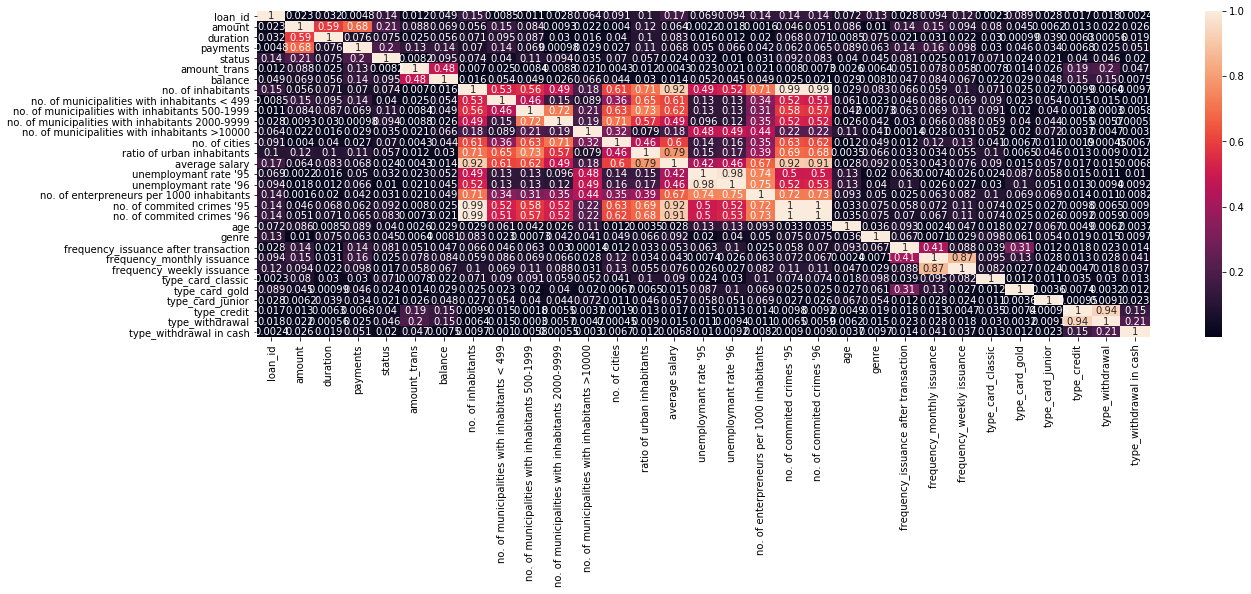

In [49]:
# Dropping ids
#train_data_no_ids = train_data.drop(['loan_id', 'account_id', 'district_id', 'disp_id', 'client_id', 'card_id', 'trans_id'], axis=1)
train_data_no_ids = train_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)
test_data_no_ids = test_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)


# Create correlation matrix
corr_matrix = train_data_no_ids.corr().abs()
plt.figure(figsize = (20,6))
sb.heatmap(corr_matrix, annot=True)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_data_no_ids.drop(to_drop, axis=1, inplace=True)
test_data_no_ids.drop(to_drop, axis=1, inplace=True)

print("{} Dropped columns: {}".format(len(to_drop), to_drop) )

In [50]:
train_data_no_ids.head()

loan_id   amount  duration  payments  status  amount_trans  balance  \
0   5314.0  96396.0      12.0    8033.0    -1.0        1100.0   1100.0   
1   5314.0  96396.0      12.0    8033.0    -1.0        9900.0  11000.0   
2   5314.0  96396.0      12.0    8033.0    -1.0        5800.0  16800.0   
3   5314.0  96396.0      12.0    8033.0    -1.0        3300.0  20100.0   
4   6903.0  52128.0      24.0    2172.0     1.0         900.0    900.0   

   no. of inhabitants  no. of municipalities with inhabitants < 499  \
0             94812.0                                          15.0   
1             94812.0                                          15.0   
2             94812.0                                          15.0   
3             94812.0                                          15.0   
4             94812.0                                          15.0   

   no. of municipalities with inhabitants 500-1999  ...  genre  \
0                                             13.0  ...      0   
1                                             13.0  ...      0   
2                                             13.0  ...      0   
3                                             13.0  ...      0   
4                                             13.0  ...      0   

   frequency_issuance after transaction  frequency_monthly issuance  \
0                                 False                       False   
1                                 False                       False   
2                                 False                       False   
3                                 False                       False   
4                                 False                        True   

   frequency_weekly issuance  type_card_classic  type_card_gold  \
0                       True              False           False   
1                       True              False           False   
2                       True              False           False   
3                       True              False           False   
4                      False              False           False   

   type_card_junior  type_credit  type_withdrawal  type_withdrawal in cash  
0             False         True            False                    False  
1             False         True            False                    False  
2             False         True            False                    False  
3             False         True            False                    False  
4             False         True            False                    False  

[5 rows x 28 columns]

In [51]:
# Removing rows with nan values for status
#train_data_no_ids.dropna(subset=["status"], inplace=True)

#print(no_ids.drop_duplicates(inplace=True)
print(train_data_no_ids["status"].value_counts())

 1.0    21524
-1.0     2970
Name: status, dtype: int64


In [52]:
train_data_no_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 28 columns):
loan_id                                             24494 non-null float64
amount                                              24494 non-null float64
duration                                            24494 non-null float64
payments                                            24494 non-null float64
status                                              24494 non-null float64
amount_trans                                        24494 non-null float64
balance                                             24494 non-null float64
no. of inhabitants                                  24494 non-null float64
no. of municipalities with inhabitants < 499        24494 non-null float64
no. of municipalities with inhabitants 500-1999     24494 non-null float64
no. of municipalities with inhabitants 2000-9999    24494 non-null float64
no. of municipalities with inhabitants >10000       24494 non-null

In [53]:
train_data_no_ids.head()

loan_id   amount  duration  payments  status  amount_trans  balance  \
0   5314.0  96396.0      12.0    8033.0    -1.0        1100.0   1100.0   
1   5314.0  96396.0      12.0    8033.0    -1.0        9900.0  11000.0   
2   5314.0  96396.0      12.0    8033.0    -1.0        5800.0  16800.0   
3   5314.0  96396.0      12.0    8033.0    -1.0        3300.0  20100.0   
4   6903.0  52128.0      24.0    2172.0     1.0         900.0    900.0   

   no. of inhabitants  no. of municipalities with inhabitants < 499  \
0             94812.0                                          15.0   
1             94812.0                                          15.0   
2             94812.0                                          15.0   
3             94812.0                                          15.0   
4             94812.0                                          15.0   

   no. of municipalities with inhabitants 500-1999  ...  genre  \
0                                             13.0  ...      0   
1                                             13.0  ...      0   
2                                             13.0  ...      0   
3                                             13.0  ...      0   
4                                             13.0  ...      0   

   frequency_issuance after transaction  frequency_monthly issuance  \
0                                 False                       False   
1                                 False                       False   
2                                 False                       False   
3                                 False                       False   
4                                 False                        True   

   frequency_weekly issuance  type_card_classic  type_card_gold  \
0                       True              False           False   
1                       True              False           False   
2                       True              False           False   
3                       True              False           False   
4                      False              False           False   

   type_card_junior  type_credit  type_withdrawal  type_withdrawal in cash  
0             False         True            False                    False  
1             False         True            False                    False  
2             False         True            False                    False  
3             False         True            False                    False  
4             False         True            False                    False  

[5 rows x 28 columns]

In [54]:
all_inputs = train_data_no_ids[train_data_no_ids.columns.drop(['loan_id', 'status'])]
all_labels = train_data_no_ids['status'].values

# competition_inputs = test_data_no_ids.drop(columns=["loan_id"])
# all_ids_comp = test_data_no_ids['loan_id'].values

#all_inputs = train_data_no_ids.iloc[:, :-1].values
#all_labels = train_data_no_ids.iloc[:, -1].values

In [55]:
# get a test dataset with 25% of the credit_data_subset
(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

#### [back](#index)
## Classifiers <a class="anchor" id="classifiers"></a>

In [ ]:
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)
lr = LogisticRegression()
nb = GaussianNB()
rf = RandomForestClassifier(300)
xgb = XGBClassifier()
mlp = MLPClassifier(alpha=1, max_iter=1000)
boost = AdaBoostClassifier()
vote = VotingClassifier(
     estimators=[('dt', DecisionTreeClassifier()), ('svm', LinearSVC()), ('xgb', XGBClassifier())],
     voting='hard', weights=[1,1,1]
)

In [ ]:
classifier = DecisionTreeClassifier()
classifier = KNeighborsClassifier()
classifier = SVC(probability=True)
classifier = LogisticRegression()
classifier = GaussianNB()
classifier = RandomForestClassifier(300)
classifier = XGBClassifier()
classifier = MLPClassifier(alpha=1, max_iter=1000)
classifier = AdaBoostClassifier()
classifier = VotingClassifier(
     estimators=[('dt', DecisionTreeClassifier()), ('svm', LinearSVC()), ('xgb', XGBClassifier())],
     voting='hard', weights=[1,1,1]
)

#### [back](#index)
## Decision Tree <a class="anchor" id="decision-tree"></a>



Classification report:
              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99       734
         1.0       1.00      1.00      1.00      5390

    accuracy                           1.00      6124
   macro avg       0.99      0.99      0.99      6124
weighted avg       1.00      1.00      1.00      6124




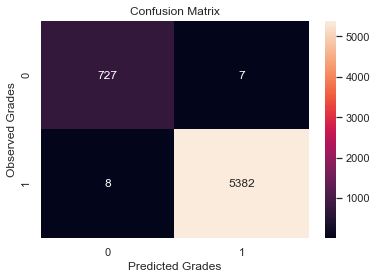

In [56]:
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

dtc_prediction = decision_tree_classifier.predict(X_test)

dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)
 
ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()


### Parameter Tunning <a class="anchor" id="parameter-tunning"></a>

In [ ]:
parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': range(10, 20),
                  'max_features': range(10,20)}

grid_search = GridSearchCV(DecisionTreeClassifier(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

In [ ]:
decision_tree_classifier = grid_search.best_estimator_
dtc_prediction = decision_tree_classifier.predict(X_test)

best_dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## K-Nearest Neighbor <a class="anchor" id="k-nearest-neighbor"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.81      0.97      0.89       734
         1.0       1.00      0.97      0.98      5390

    accuracy                           0.97      6124
   macro avg       0.90      0.97      0.93      6124
weighted avg       0.97      0.97      0.97      6124




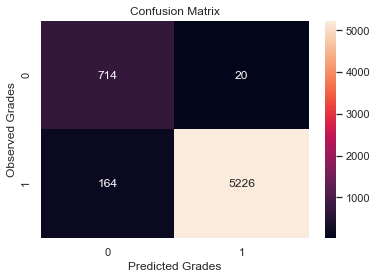

In [57]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)

knn_classification_report = classification_report(y_test, knn_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, knn_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, knn_prediction)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

### Parameter Tunning <a class="anchor" id="parameter-tunning-2"></a>

In [ ]:
parameter_grid = {'n_neighbors': [5,10,15,20],
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid=parameter_grid,
                           scoring='precision_weighted',
                           cv=10,
                           n_jobs=3,
                           verbose=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
knn = grid_search.best_estimator_
yk_pred = knn.predict(X_test)

best_knn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_knn = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_knn, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Support-Vector Machines <a class="anchor" id="support-vector-machines"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.26      0.69      0.37       734
         1.0       0.94      0.73      0.82      5390

    accuracy                           0.72      6124
   macro avg       0.60      0.71      0.60      6124
weighted avg       0.86      0.72      0.77      6124




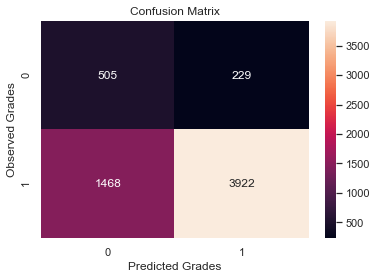

In [58]:
svc = SVC(probability=True)

svc.fit(X_train, y_train)
svc_prediction = svc.predict(X_test)

svm_classification_report = classification_report(y_test, svc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, svc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, svc_prediction)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_svm_classification_report = svm_classification_report

### Parameter Tunning <a class="anchor" id="parameter-tunning-3"></a>

In [ ]:
parameter_grid = {'C' : [0.1, 1, 10], 
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid_search = GridSearchCV(SVC(),
                           param_grid=parameter_grid,
                           cv=10,
                           verbose=4,
                           n_jobs=4)

grid_search.fit(X_train, y_train)
print(f"Best score: {grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best estimator: {grid_search.best_estimator_}")

In [ ]:
svc = grid_search.best_estimator_
yk_pred = svc.predict(X_test)

best_svm_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_knn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_svm = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_svm, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Neural Networks <a class="anchor" id="neural-networks"></a>

              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       734
         1.0       1.00      1.00      1.00      5390

    accuracy                           1.00      6124
   macro avg       1.00      1.00      1.00      6124
weighted avg       1.00      1.00      1.00      6124



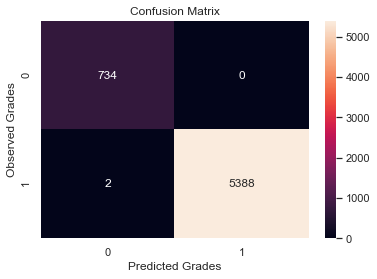

In [59]:
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train_nn = scaler.transform(X_train)
X_test_nn = scaler.transform(X_test)

# Create the classifier
ANNClassifier = MLPClassifier(random_state=1, max_iter=500)

# Train the classifier on the training set
ANNClassifier.fit(X_train_nn, y_train)

predictions = ANNClassifier.predict(X_test_nn)

confusion_matrix_ann = confusion_matrix(y_test,predictions)

nn_classification_report = classification_report(y_test, predictions, output_dict=True)
print(classification_report(y_test,predictions))

sb.set(font_scale=1.0)

ax = plt.subplot()

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

best_nn_classification_report = nn_classification_report

### Parameter Tunning <a class="anchor" id="parameter-tunning-4"></a>

In [ ]:
parameter_grid = {'activation': ['tanh','identity','logistic','relu'],
                  'solver': ['adam','lbfgs','sgd'],
                  'hidden_layer_sizes': [3,5,8,13,21,34],
                  'verbose': [True]}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True)

grid_search = GridSearchCV(ANNClassifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

In [ ]:
ANNClassifier = grid_search.best_estimator_
yk_pred = ANNClassifier.predict(X_test)

best_nn_classification_report = classification_report(y_test, yk_pred, output_dict=True)

print("--- Improved model ---\n")
print(f"Classification report:\n{best_nn_classification_report(y_test, yk_pred)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_ann = confusion_matrix(y_test, yk_pred)

sb.heatmap(confusion_matrix_ann, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Logistic Regression <a class="anchor" id="logistic-regression"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.21      0.60      0.32       734
         1.0       0.93      0.70      0.80      5390

    accuracy                           0.69      6124
   macro avg       0.57      0.65      0.56      6124
weighted avg       0.84      0.69      0.74      6124




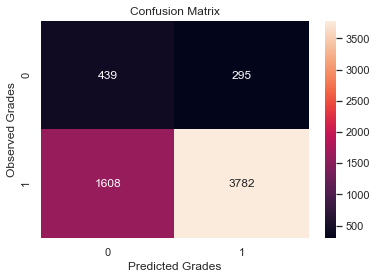

In [60]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)

lr_classification_report = classification_report(y_test, lr_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, lr_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_lr = confusion_matrix(y_test, lr_prediction)

sb.heatmap(confusion_matrix_lr, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Naive Bayes <a class="anchor" id="naive-bayes"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.21      0.53      0.30       734
         1.0       0.92      0.73      0.82      5390

    accuracy                           0.71      6124
   macro avg       0.57      0.63      0.56      6124
weighted avg       0.83      0.71      0.75      6124




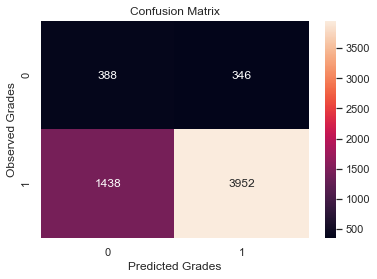

In [61]:
nb = GaussianNB()

nb.fit(X_train, y_train)
nb_prediction = nb.predict(X_test)

nb_classification_report = classification_report(y_test, nb_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, nb_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_nb = confusion_matrix(y_test, nb_prediction)

sb.heatmap(confusion_matrix_nb, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Random Forest <a class="anchor" id="random-forest"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       734
         1.0       1.00      1.00      1.00      5390

    accuracy                           1.00      6124
   macro avg       1.00      1.00      1.00      6124
weighted avg       1.00      1.00      1.00      6124




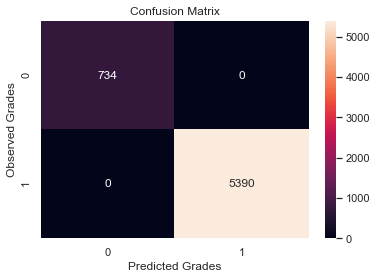

In [67]:
rf = RandomForestClassifier(300)

rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)

rf_classification_report = classification_report(y_test, rf_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, rf_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_rf = confusion_matrix(y_test, rf_prediction)

sb.heatmap(confusion_matrix_rf, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## XGBoost <a class="anchor" id="xgboost"></a>

In [63]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)
xgb_prediction = xgb.predict(X_test)

xgb_classification_report = classification_report(y_test, xgb_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, xgb_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_xgb = confusion_matrix(y_test, xgb_prediction)

sb.heatmap(confusion_matrix_xgb, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

C:\Users\pedro\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: feature_names must be string, and may not contain [, ] or <

#### [back](#index)
## MLP <a class="anchor" id="mlp"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.26      0.84      0.40       734
         1.0       0.97      0.67      0.79      5390

    accuracy                           0.69      6124
   macro avg       0.61      0.76      0.60      6124
weighted avg       0.88      0.69      0.75      6124




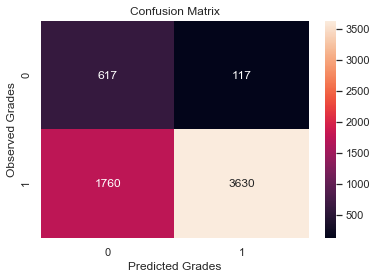

In [64]:
mlp = MLPClassifier(alpha=1, max_iter=1000)

mlp.fit(X_train, y_train)
mlp_prediction = mlp.predict(X_test)

mlp_classification_report = classification_report(y_test, mlp_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, mlp_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_mlp = confusion_matrix(y_test, mlp_prediction)

sb.heatmap(confusion_matrix_mlp, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Ada Boost <a class="anchor" id="ada-boost"></a>

Classification report:
              precision    recall  f1-score   support

        -1.0       0.59      0.87      0.70       734
         1.0       0.98      0.92      0.95      5390

    accuracy                           0.91      6124
   macro avg       0.78      0.89      0.82      6124
weighted avg       0.93      0.91      0.92      6124




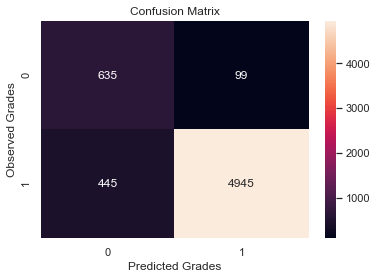

In [68]:
boost = AdaBoostClassifier()

boost.fit(X_train, y_train)
boost_prediction = boost.predict(X_test)

boost_classification_report = classification_report(y_test, boost_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, boost_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_boost = confusion_matrix(y_test, boost_prediction)

sb.heatmap(confusion_matrix_boost, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

#### [back](#index)
## Voting <a class="anchor" id="voting"></a>

In [73]:
vote = VotingClassifier(
     estimators=[('dt', DecisionTreeClassifier()), ('svm', LinearSVC()), ('xgb', XGBClassifier())],
     voting='hard', weights=[1,1,1]
)

vote.fit(X_train, y_train)
vote_prediction = vote.predict(X_test)

vote_classification_report = classification_report(y_test, vote_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, vote_prediction, labels=np.unique(y_train))}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_vote = confusion_matrix(y_test, vote_prediction)

sb.heatmap(confusion_matrix_vote, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()

C:\Users\pedro\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
C:\Users\pedro\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: feature_names must be string, and may not contain [, ] or <

In [74]:
#table = go.Figure(data=[go.Table(header=dict(values=['Algorithm', 'Accuracy Normal']),
#                 cells=dict(values=[['DT', 'KNN', 'SVM', 'NN', 'LR', 'NB', 'RF', 'XGB', 'MLP', 'BOOST', 'VOTE'], [dtc_classification_report['accuracy'], knn_classification_report['accuracy'], svm_classification_report['accuracy'], nn_classification_report['accuracy'], lr_classification_report['accuracy'], nb_classification_report['accuracy'], rf_classification_report['accuracy'], xgb_classification_report['accuracy'], mlp_classification_report['accuracy'], boost_classification_report['accuracy'], vote_classification_report['accuracy']]]))
#                     ])

table = go.Figure(data=[go.Table(header=dict(values=['Algorithm', 'Accuracy Normal']),
                 cells=dict(values=[['DT', 'KNN', 'SVM', 'NN', 'LR', 'NB', 'RF', 'MLP', 'BOOST', 'VOTE'], [dtc_classification_report['accuracy'], knn_classification_report['accuracy'], svm_classification_report['accuracy'], nn_classification_report['accuracy'], lr_classification_report['accuracy'], nb_classification_report['accuracy'], rf_classification_report['accuracy'], mlp_classification_report['accuracy'], boost_classification_report['accuracy']]]))
                     ])

table.show()

In [ ]:
test_data_no_ids.info()

#### [back](#index)
## Apply Model <a class="anchor" id="apply-model"></a>

In [75]:
test_inputs = test_data_no_ids.drop(columns=['status', 'loan_id'])

pred_comp = boost.predict_proba(test_inputs)

pred_comp = pd.DataFrame(pred_comp, columns=['col2', 'Predicted'])

pred_comp.drop('col2', axis=1, inplace=True)
all_ids_comp = pd.DataFrame(all_ids_comp, columns=['Id'])
results = pd.concat([all_ids_comp, pred_comp], axis=1)
#results = results.rename(columns={"loan_id":"Id"})
results.to_csv('results.csv', index = False)

print(results)

       Id  Predicted
0    5895   0.669139
1    5172   0.647508
2    6207   0.501171
3    7122   0.487444
4    7067   0.501583
5    6173   0.508892
6    6705   0.513390
7    5889   0.516617
8    5036   0.517313
9    6142   0.506335
10   6938   0.506268
11   5932   0.533799
12   5398   0.507871
13   6855   0.662763
14   6632   0.500986
15   5358   0.521728
16   5674   0.491327
17   5384   0.608268
18   5589   0.493444
19   5042   0.496608
20   6095   0.670062
21   7049   0.510023
22   6075   0.514548
23   6878   0.617230
24   5790   0.488603
25   5532   0.506428
26   6118   0.493620
27   6442   0.503218
28   6554   0.491954
29   5973   0.498414
..    ...        ...
324  7279   0.495763
325  5463   0.749068
326  6355   0.495809
327  6675   0.494419
328  5620   0.429820
329  4988   0.491640
330  5765   0.505780
331  7091   0.507149
332  5933   0.512468
333  6470   0.491653
334  5841   0.534690
335  6574   0.512496
336  5525   0.507979
337  5435   0.496642
338  7168   0.497941
339  5909   0